# 0.0. IMPORTS

In [158]:
import math
import numpy  as np
import pandas as pd
import inflection
import seaborn as sns

from scipy                 import stats
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML

from datetime import datetime
from datetime import timedelta

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder



## 0.0 Change Themes

In [2]:
# Para ver lista de temas
# jt -l
# Available Themes:
#    chesterish
#    grade3
#    gruvboxd
#    gruvboxl
#    monokai
#    oceans16
#    onedork
#    solarizedd
#    solarizedl
# Para setar um tema
# !jt -t solarizedd -T -N -kl
# Para resetar o tema
# !jt -r

In [3]:
# !jt -t gruvboxd -T -N -kl

## 0.1. Helper Functions

In [4]:
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    phi2 = chi2/n
    phi2corr = max(0,phi2-(k-1)*(r-1)/(n-1))
    
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((phi2corr)/(min(kcorr-1,rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    #pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [5]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/Users/igor/.pyenv/versions/3.8.0/envs/venv_ds-em-producao/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2. Loading data

In [6]:
# df_sales_raw = pd.read_csv( '../data/train.csv', low_memory=False )
# df_store_raw = pd.read_csv( '../data/store.csv', low_memory=False )
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. PASSO 01 - DESCRICAO DOS DADOS

In [7]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [9]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [10]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

O código original estava demorando 4 minutos para ser executado. 
O novo código, utilizando o comando loc e str.split foi executado em 7 segundos.

In [12]:
# 08/05/22: Vou usar um dataframe auxiliar para fazer os preenchimentos de células vazias. Tentei substituir os valores no dataframe original e estava tendo problemas.
df_aux = df1

In [13]:
# df1.sample()
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


O código original estava demorando 4 minutos para ser executado. 
O novo código, utilizando o comando loc e str.split foi executado em 7 segundos.

In [14]:
#competition_distance        

df1.loc[df1.competition_distance.isna(),'competition_distance'] = 200000.0

#competition_open_since_month

df1['competition_open_since_month'] = np.where(df_aux['competition_open_since_month'].isna() == True, df_aux.date.dt.month, df_aux['competition_open_since_month'])

#competition_open_since_year 

df1['competition_open_since_year'] = np.where(df_aux['competition_open_since_year'].isna() == True, df_aux.date.dt.year, df_aux['competition_open_since_year'])

#promo2_since_week          

df1['promo2_since_week'] = np.where(df_aux['promo2_since_week'].isna() == True, df_aux.date.dt.week, df_aux['promo2_since_week'])

#promo2_since_year    

df1['promo2_since_year'] = np.where(df_aux['promo2_since_year'].isna() == True, df_aux.date.dt.year, df_aux['promo2_since_year'])

#promo_interval              
month_map = {1: 'Jan',  2: 'Feb',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sept',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1[['m1','m2','m3','m4']] = df1['promo_interval'].str.split( ',' , expand = True)
df1['is_promo3'] = 0
df1.loc[(df1.month_map == df1.m1) | (df1.month_map == df1.m2 ) | (df1.month_map == df1.m3 ) | (df1.month_map == df1.m4), 'is_promo3' ] = 1

df1.drop(columns=['m1','m2','m3','m4'],inplace=True)

df1.head(20)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo3
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul,0
5,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.0,12.0,2013.0,0,31.0,2015.0,0,Jul,0
6,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,4.0,2013.0,0,31.0,2015.0,0,Jul,0
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.0,10.0,2014.0,0,31.0,2015.0,0,Jul,0
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8.0,2000.0,0,31.0,2015.0,0,Jul,0
9,10,5,2015-07-31,7185,681,1,1,0,1,a,a,3160.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0


In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo3                       0
dtype: int64

## 1.6. Change Data Types

In [16]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7. Descriptive Statistics

In [17]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Atributes

In [18]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


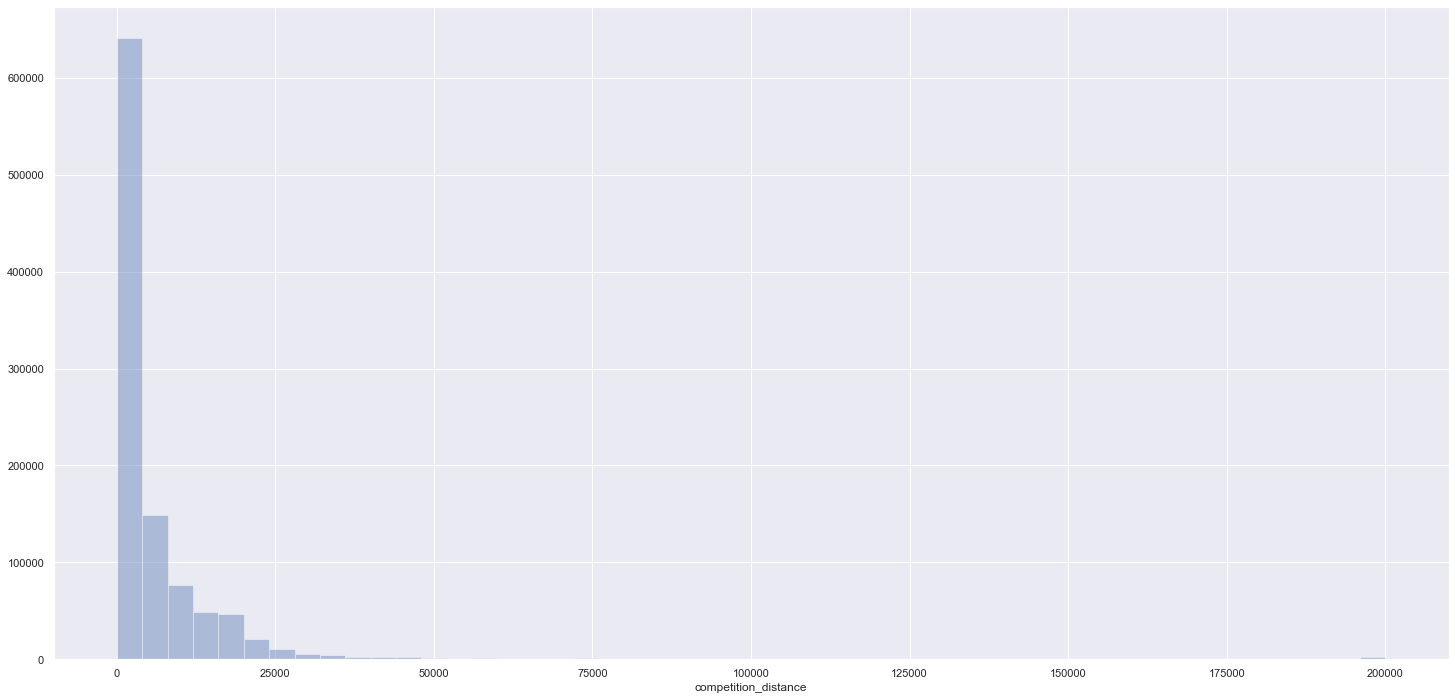

In [19]:
sns.distplot( df1['competition_distance'], kde=False )

Outra forma de fazer a tabela de estatísticas

In [20]:
num_attributes.agg(["mean","median","std","min","max","skew","kurtosis"]).T

,mean,median,std,min,max,skew,kurtosis
store,558.429727,558.0,321.908651,1.0,1115.0,-0.000955,-1.200524
day_of_week,3.998341,4.0,1.997391,1.0,7.0,0.001593,-1.246873
sales,5773.818972,5744.0,3849.926175,0.0,41551.0,0.641460,1.778375
customers,633.145946,609.0,464.411734,0.0,7388.0,1.598650,7.091773
open,0.830107,1.0,0.375539,0.0,1.0,-1.758045,1.090723
promo,0.381515,0.0,0.485759,0.0,1.0,0.487838,-1.762018
school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.677842,0.815154
competition_distance,5935.442677,2330.0,12547.652996,20.0,200000.0,10.242344,147.789712
competition_open_since_month,6.786849,7.0,3.311087,1.0,12.0,-0.042076,-1.232607
competition_open_since_year,2010.324840,2012.0,5.515593,1900.0,2015.0,-7.235657,124.071304


### 1.7.2. Categorical Atributes

In [21]:
cat_attributes

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul
...,...,...,...,...,...
1017204,a,a,a,"Jan,Apr,Jul,Oct",Jan
1017205,a,c,c,0,Jan
1017206,a,a,c,0,Jan
1017207,a,a,c,0,Jan


In [22]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [23]:
cat_attributes.state_holiday.unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [24]:
cat_attributes.state_holiday.value_counts()

0    986159
a     20260
b      6690
c      4100
Name: state_holiday, dtype: int64

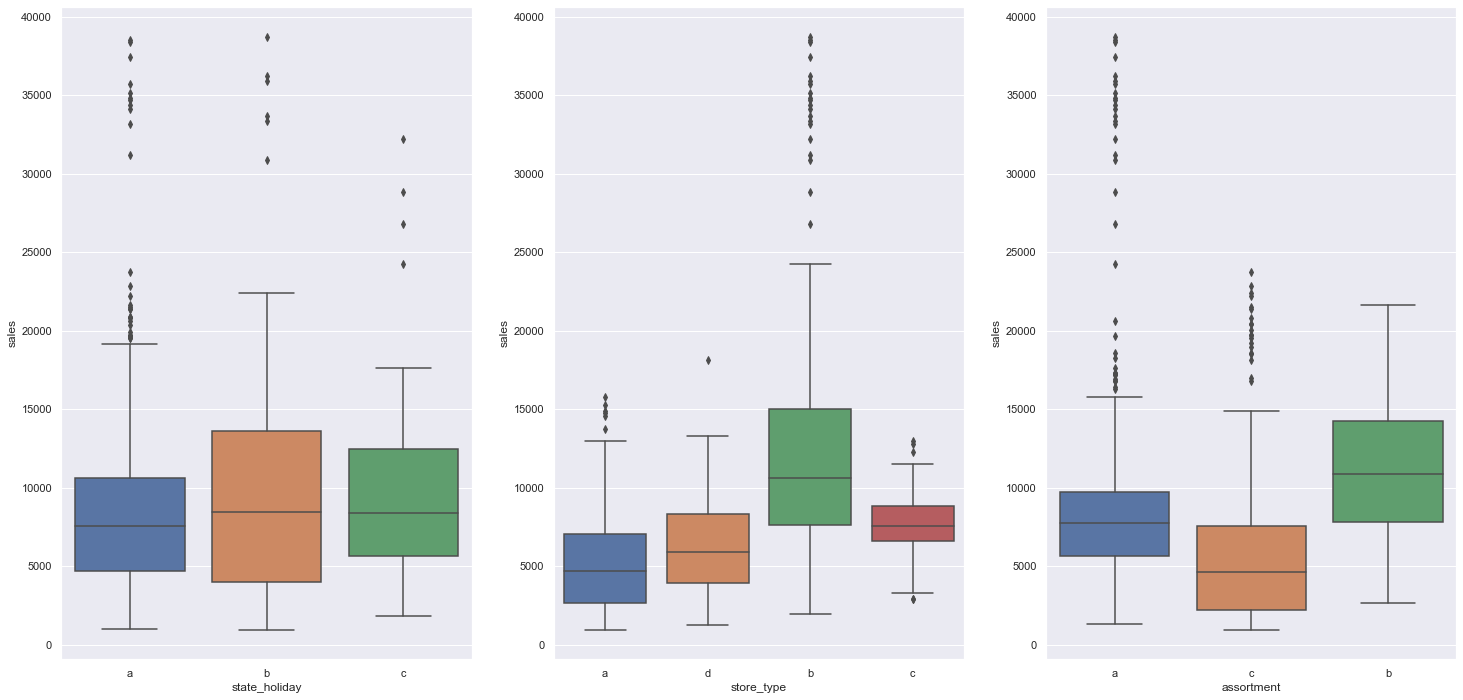

In [25]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [26]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

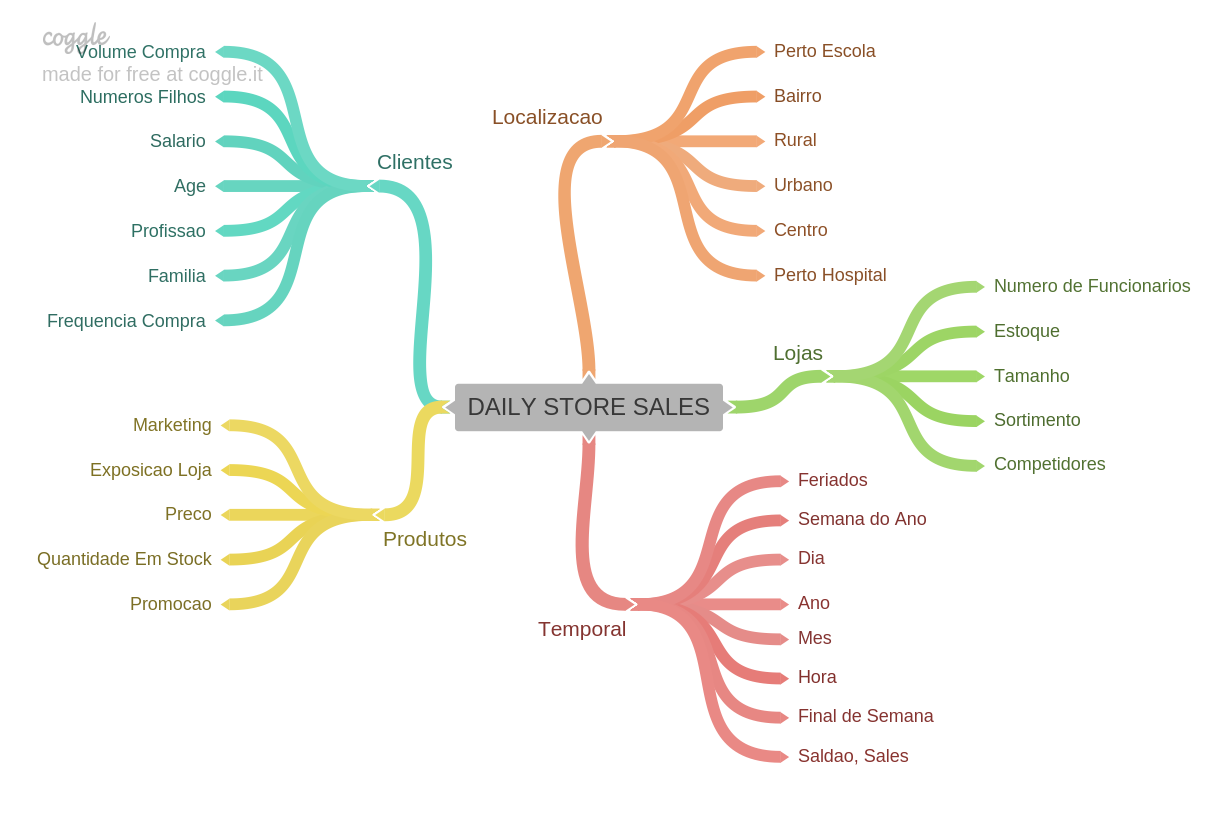

In [27]:
Image( 'img/MindMapHypothesis.png' )

## 2.2. Criacao das Hipoteses

### 2.2.1. Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4. Feature Engineering

Otimizei essa parte
Tempo de Execução : 24.5s
Tempo de Execução original: 4m

In [28]:
# A criação das 5 primeiras colunas leva 18s no VS Code. No Jupyter leva 15s.
# Não sei se é possível otimizar esse trecho

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# Tempo de execução: 3.64s
# competition since
# Criando a data completa de início da competição
aux_str = df2['competition_open_since_year'].astype(str) + '-' + df2['competition_open_since_month'].astype(str) + '-1'
df2['competition_since'] = pd.to_datetime(aux_str)

# Tempo de execução: 367ms
aux_delta_days = ( df2['date'] - df2['competition_since'] )
df2['competition_time_month'] = (aux_delta_days/30).dt.days

# Tempo de execução 3.6s
aux_str = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str ) + '-1'
df2['promo_since'] = pd.to_datetime(aux_str,format="%Y-%W-%w") - timedelta(7)

# Tempo de execução: 388ms
aux_delta_days = ( df2['date'] - df2['promo_since'] )
df2['promo_time_week'] = (aux_delta_days/7).dt.days

# Tempo de execução: 443ms
df2['assortment'] = 'basic'
df2.loc[df1.assortment == 'b', 'assortment'] = 'extra'
df2.loc[df1.assortment == 'c', 'assortment'] = 'extended'

# Tempo de Execução 393ms
df2['state_holiday'] = 'regular_day'
df2.loc[df1.state_holiday == 'a', 'state_holiday'] = 'public_holiday'
df2.loc[df1.state_holiday == 'b', 'state_holiday'] = 'easter_holiday'
df2.loc[df1.state_holiday == 'c', 'state_holiday'] = 'christmas'

### competition since
### Criando a data completa de início da competição

In [29]:
# Tempo de execução: 3.64s
# competition since
# Criando a data completa de início da competição
# aux_str = df2['competition_open_since_year'].astype(str) + '-' + df2['competition_open_since_month'].astype(str) + '-1'
# df2['competition_since2'] = pd.to_datetime(aux_str)
# df2[['competition_since','competition_open_since_year','competition_open_since_month','competition_since2']]

In [30]:
# df2[['competition_since','competition_open_since_year','competition_open_since_month','competition_since2']].info()

In [31]:
# aux = df2['competition_open_since_year'][0].astype(str) + '-' + df2['competition_open_since_month'][0].astype(str) + '-' + '1'
# aux 

In [32]:
# aux_dt = pd.to_datetime(aux)
# aux_dt

In [33]:
# df2['competition_since'][0]

In [34]:
# #aux = df2['competition_open_since_year'][0].astype(str) + '-' + df2['competition_open_since_month'][0].astype(str) + '-' + '1'
# aux = df2['competition_open_since_year'].astype(str) + '-' + df2['competition_open_since_month'].astype(str) + '-' + '1'
# aux

In [35]:
# aux_dt = pd.to_datetime(aux)
# aux_dt

In [36]:
# # Tempo de execução: 51s
# # competition since
# # Criando a data completa de início da competição
# df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )

In [37]:
# df2[['competition_since','competition_open_since_year','competition_open_since_month']]

### df2['competition_time_month']

In [38]:
# Tempo de execução: 367ms
# aux_delta_days = ( df2['date'] - df2['competition_since'] )
# df2['competition_time_month2'] = (aux_delta_days/30).dt.days
# df2[['competition_time_month', 'date', 'competition_since', 'competition_time_month2' ]]

In [39]:
# # Para uma linha
# aux_delta_days = ( df2['date'][0] - df2['competition_since'][0] )
# print(aux_delta_days)
# aux_delta_months = aux_delta_days/30
# print(aux_delta_months)

In [40]:
# aux_delta_days = ( df2['date'] - df2['competition_since'] )
# aux_delta_months = (aux_delta_days/30).dt.days
# print(aux_delta_months)


In [41]:
# df2[['competition_time_month', 'date', 'competition_since' ]]

In [42]:
# Tempo de execução: 20.3s
# Cria a coluna de quantidade de meses desde que existe competição. 
# A subtração de datas gera uma variável do tipo Timedelta('2524 days 00:00:00')
# Para retirar o número de meses, ela é dividida por 30 e depois a função days é aplicada em todas as linhas

# df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

### promo since

In [43]:
# Tempo de execução 3.6s
# aux_str = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str ) + '-1'
# df2['promo_since2'] = pd.to_datetime(aux_str,format="%Y-%W-%w") - timedelta(7)
# df2[['promo2_since_year','promo2_since_week','promo_since','promo_since2']]

In [44]:
# aux_str = df2['promo2_since_year'][0].astype( str ) + '-' + df2['promo2_since_week'][0].astype( str )
# aux_str

In [45]:
# aux_dt = pd.to_datetime(aux_str,format='%Y-%W')
# aux_dt

In [46]:
# aux_str = df2['promo2_since_year'][0].astype( str ) + '-' + df2['promo2_since_week'][0].astype( str ) + '-1'
# aux_str

In [47]:
# aux_dt = pd.to_datetime(aux_str,format="%Y-%W-%w")
# aux_dt

In [48]:
# df2[['promo2_since_year','promo2_since_week','promo_since']]

In [49]:
# Tempo de execução 27.7s

# promo since
# df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
# # Antes de importar datetime precisava escrever datetime.datetime.strptime e datetime.timedelta
# #df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
# df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days=7 ) )

### 'promo_time_week'

In [50]:
# Tempo de execução: 388ms
# aux_delta_days = ( df2['date'] - df2['promo_since'] )
# df2['promo_time_week2'] = (aux_delta_days/7).dt.days
# df2[['date', 'promo_since', 'promo_time_week', 'promo_time_week2' ]]

In [51]:
# Tempo de execução: 21.7s
# Mesma lógica da coluna 'competition_time_month'
# df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

### assortment e state holiday

In [52]:
# Tempo de execução: 443ms
# df2['assortment2'] = 'basic'
# df2.loc[df1.assortment == 'b', 'assortment2'] = 'extra'
# df2.loc[df1.assortment == 'c', 'assortment2'] = 'extended'

# # state holiday
# df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [53]:
# df2['state_holiday2'] = 'regular_day'
# df2.loc[df1.state_holiday == 'a', 'state_holiday2'] = 'public_holiday'
# df2.loc[df1.state_holiday == 'b', 'state_holiday2'] = 'easter_holiday'
# df2.loc[df1.state_holiday == 'c', 'state_holiday2'] = 'christmas'

In [54]:
# df2.state_holiday.value_counts()

In [55]:
# df2[['assortment','assortment2','state_holiday','state_holiday2']]

In [56]:
# df1.assortment.value_counts()

In [57]:
# # Tempo de execução: 606ms
# # assortment
# df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# # state holiday
# df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

### Código original 
Levando 4 minutos para rodar

In [58]:
# # year
# df2['year'] = df2['date'].dt.year

# # month
# df2['month'] = df2['date'].dt.month

# # day
# df2['day'] = df2['date'].dt.day

# # week of year
# df2['week_of_year'] = df2['date'].dt.weekofyear

# # year week
# df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# # competition since
# # Criando a data completa de início da competição
# df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )

# # Cria a coluna de quantidade de meses desde que existe competição. 
# # A subtração de datas gera uma variável do tipo Timedelta('2524 days 00:00:00')
# # Para retirar o número de meses, ela é dividida por 30 e depois a função days é aplicada em todas as linhas

# df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# # promo since
# df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
# # Antes de importar datetime precisava escrever datetime.datetime.strptime e datetime.timedelta
# #df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
# df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days=7 ) )

# # Mesma lógica da coluna 'competition_time_month'
# df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# # assortment
# df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# # state holiday
# df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [59]:
df3 = df2.copy()

In [60]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo3,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas


In [61]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Selecao das Colunas

In [62]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [63]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variables

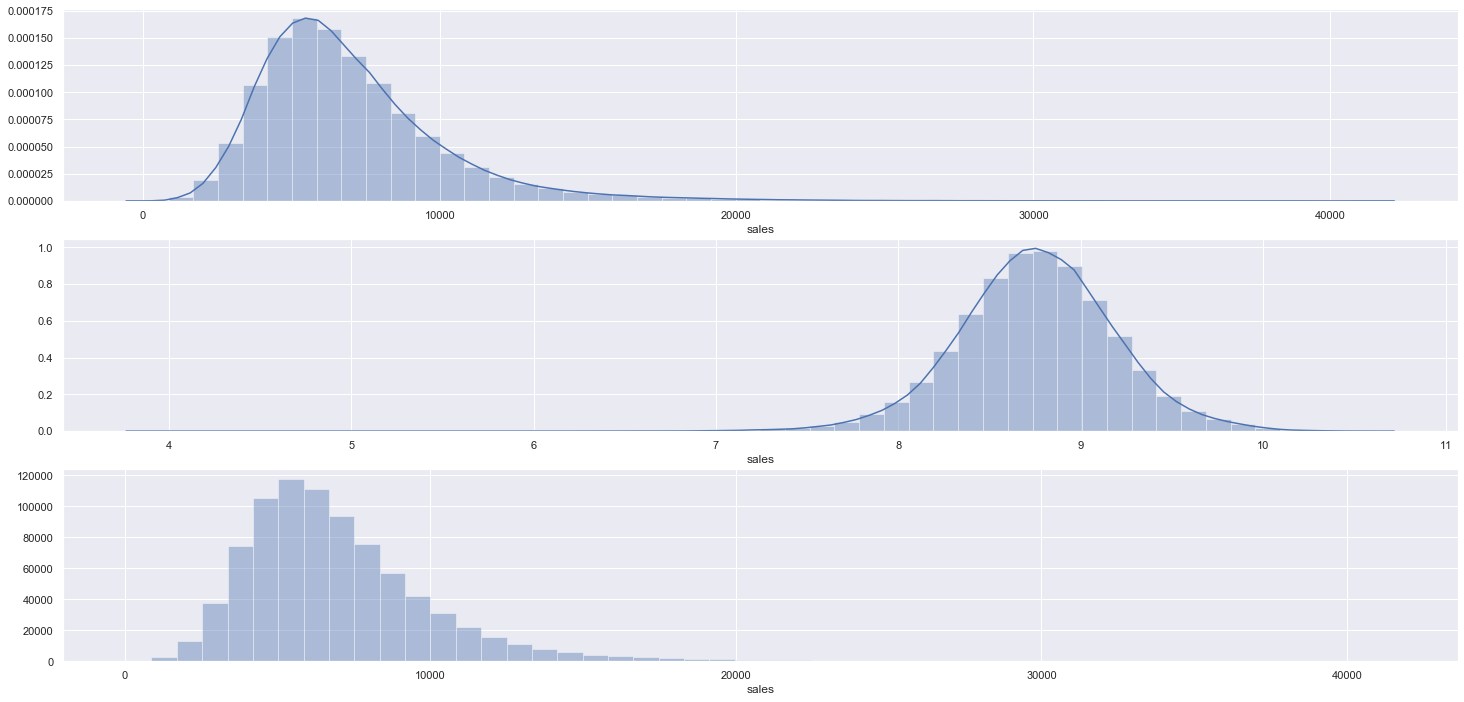

In [64]:
fig, [ax1, ax2, ax3] = subplots(3,1)

# Plot de densidade de distribuição
sns.distplot(df4.sales, ax=ax1)

# Transformação possível
sns.distplot(np.log1p(df4.sales), ax=ax2)

# Plot de histograma
sns.distplot(df4.sales, kde = False, ax=ax3)

### 4.1.2 Numerical Variables

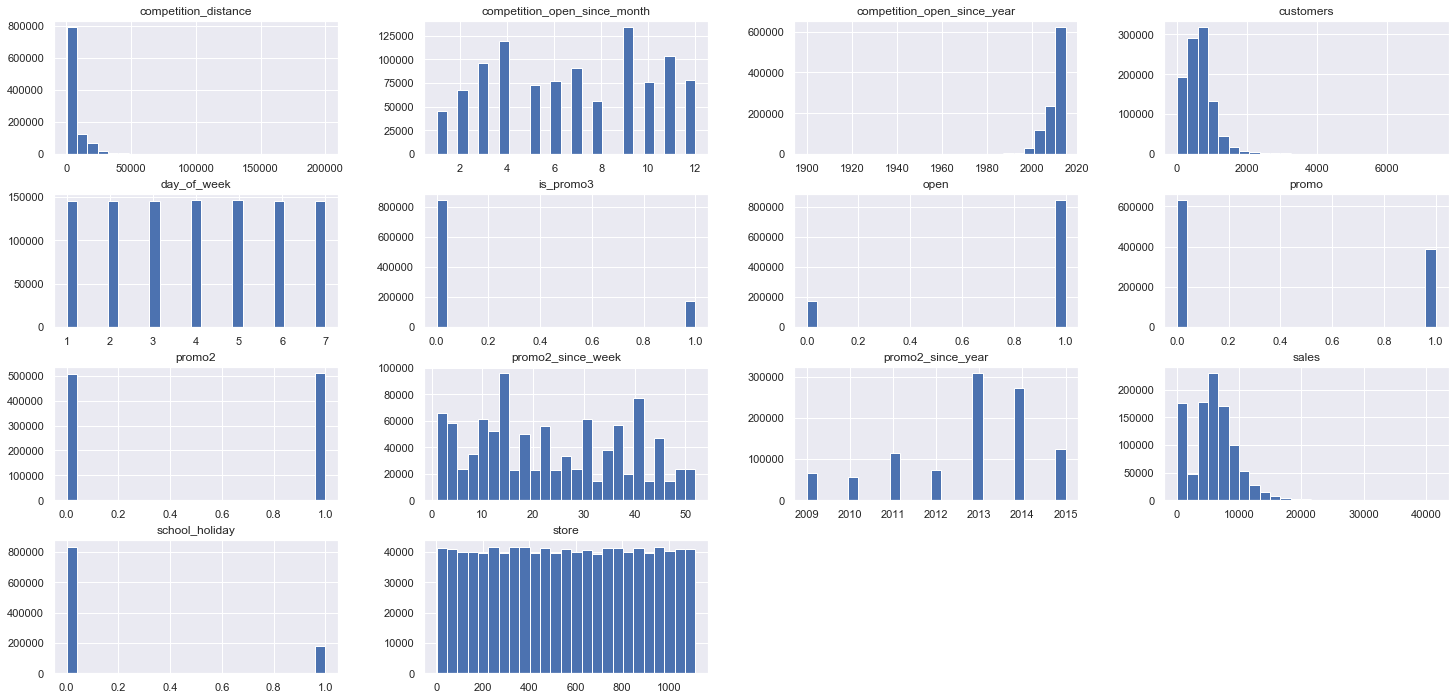

In [65]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable 

In [66]:
cat_attributes

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul
...,...,...,...,...,...
1017204,a,a,a,"Jan,Apr,Jul,Oct",Jan
1017205,a,c,c,0,Jan
1017206,a,a,c,0,Jan
1017207,a,a,c,0,Jan


In [67]:
df4.state_holiday.value_counts()

regular_day       843428
public_holiday       694
easter_holiday       145
christmas             71
Name: state_holiday, dtype: int64

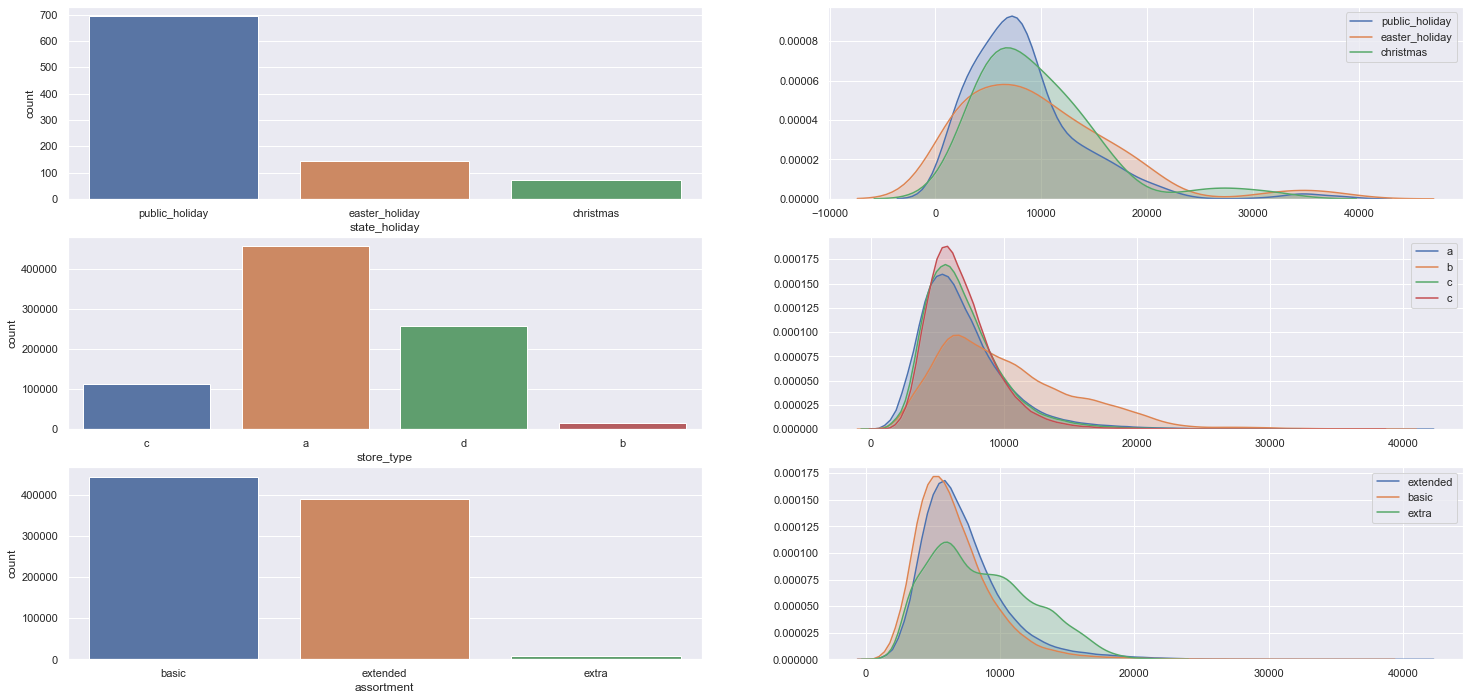

In [68]:
# state_holiday
plt.subplot(3,2,1)
# Filtragem necessária pois há muito mais 'regular_day' que outros tipos
a = df4.loc[df4.state_holiday!='regular_day']

sns.countplot(a.state_holiday)

plt.subplot(3,2,2)
sns.kdeplot(df4.loc[df4.state_holiday=='public_holiday','sales'], label='public_holiday', shade=True )
sns.kdeplot(df4.loc[df4.state_holiday=='easter_holiday','sales'], label='easter_holiday', shade=True )
sns.kdeplot(df4.loc[df4.state_holiday=='christmas','sales'], label='christmas', shade=True )

# store_type
plt.subplot(3,2,3)

sns.countplot(df4.store_type)

plt.subplot(3,2,4)
sns.kdeplot(df4.loc[df4.store_type=='a','sales'], label='a', shade=True )
sns.kdeplot(df4.loc[df4.store_type=='b','sales'], label='b', shade=True )
sns.kdeplot(df4.loc[df4.store_type=='c','sales'], label='c', shade=True )
sns.kdeplot(df4.loc[df4.store_type=='d','sales'], label='c', shade=True )

# assortment
plt.subplot(3,2,5)

sns.countplot(df4.assortment)

plt.subplot(3,2,6)
sns.kdeplot(df4.loc[df4.assortment=='extended','sales'], label='extended', shade=True )
sns.kdeplot(df4.loc[df4.assortment=='basic','sales'], label='basic', shade=True )
sns.kdeplot(df4.loc[df4.assortment=='extra','sales'], label='extra', shade=True )


## 4.2 Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais.

Essa hipótese me parece correta mas Meigarom concluiu que ela está errada pois fez um gráfico com a soma de todas as lojas de cada tipo. Como tem menos lojas do tipo Extra, a soma total deu menor que dos outros tipos. Porém se as médias forem olhadas, a hipótese será confirmada.

O número de lojas do tipo Extra é muito menor que dos outros tipos

In [69]:
df4.assortment.value_counts()

basic       444875
extended    391254
extra         8209
Name: assortment, dtype: int64

In [70]:
aux_sum = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
aux_mean = df4[['assortment','sales']].groupby('assortment').mean().reset_index()
display(aux_sum)
display(aux_mean)

,assortment,sales
0,basic,2945750070
1,extended,2856484241
2,extra,70946312


,assortment,sales
0,basic,6621.523057
1,extended,7300.843547
2,extra,8642.503594


Text(0.5, 1.0, 'Média de vendas')

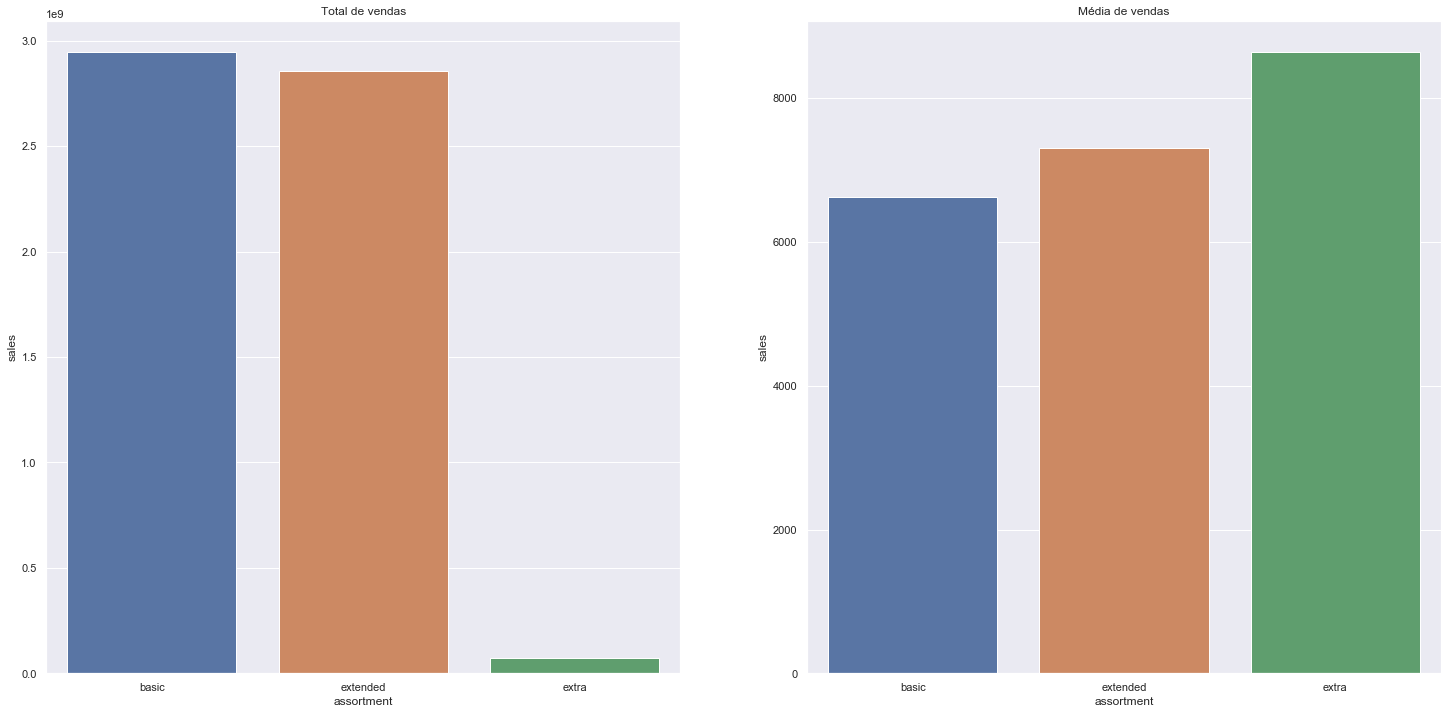

In [71]:
# Total de vendas para cada tipo
subplot(1,2,1)
sns.barplot(x='assortment',y='sales',data=aux_sum)
plt.title('Total de vendas')

# Média de vendas para cada tipo
subplot(1,2,2)
sns.barplot(x='assortment',y='sales',data=aux_mean)
plt.title('Média de vendas')

In [72]:
aux_sum = df4[['assortment','year_week','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux_mean = df4[['assortment','year_week','sales']].groupby(['year_week','assortment']).mean().reset_index()
display( aux_sum )
display( aux_mean )

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693
...,...,...,...
406,2015-29,extended,19570832
407,2015-29,extra,574020
408,2015-30,basic,23492454
409,2015-30,extended,23301780


,year_week,assortment,sales
0,2013-00,basic,5642.277194
1,2013-00,extended,6094.001471
2,2013-00,extra,5282.431373
3,2013-01,basic,7307.459961
4,2013-01,extended,7553.623270
...,...,...,...
406,2015-29,extended,6327.459425
407,2015-29,extra,9111.428571
408,2015-30,basic,7950.069036
409,2015-30,extended,9084.514620


In [73]:
display(aux_sum.pivot(index = 'year_week', columns = 'assortment', values = 'sales'))
display(aux_mean.pivot(index = 'year_week', columns = 'assortment', values = 'sales'))

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061
...,...,...,...
2015-26,27840342,27165959,684180
2015-27,20356210,20449036,586036
2015-28,25746704,25629698,632017


assortment,basic,extended,extra
year_week,,,
2013-00,5642.277194,6094.001471,5282.431373
2013-01,7307.459961,7553.623270,6254.982143
2013-02,5049.444788,5283.317073,6286.783333
2013-03,6853.631919,6983.376397,6423.206349
2013-04,5611.939028,5944.287541,6483.232143
...,...,...,...
2015-26,7807.162647,8788.728243,10860.000000
2015-27,5710.016830,6624.242306,9302.158730
2015-28,7238.319933,8299.772668,10032.015873


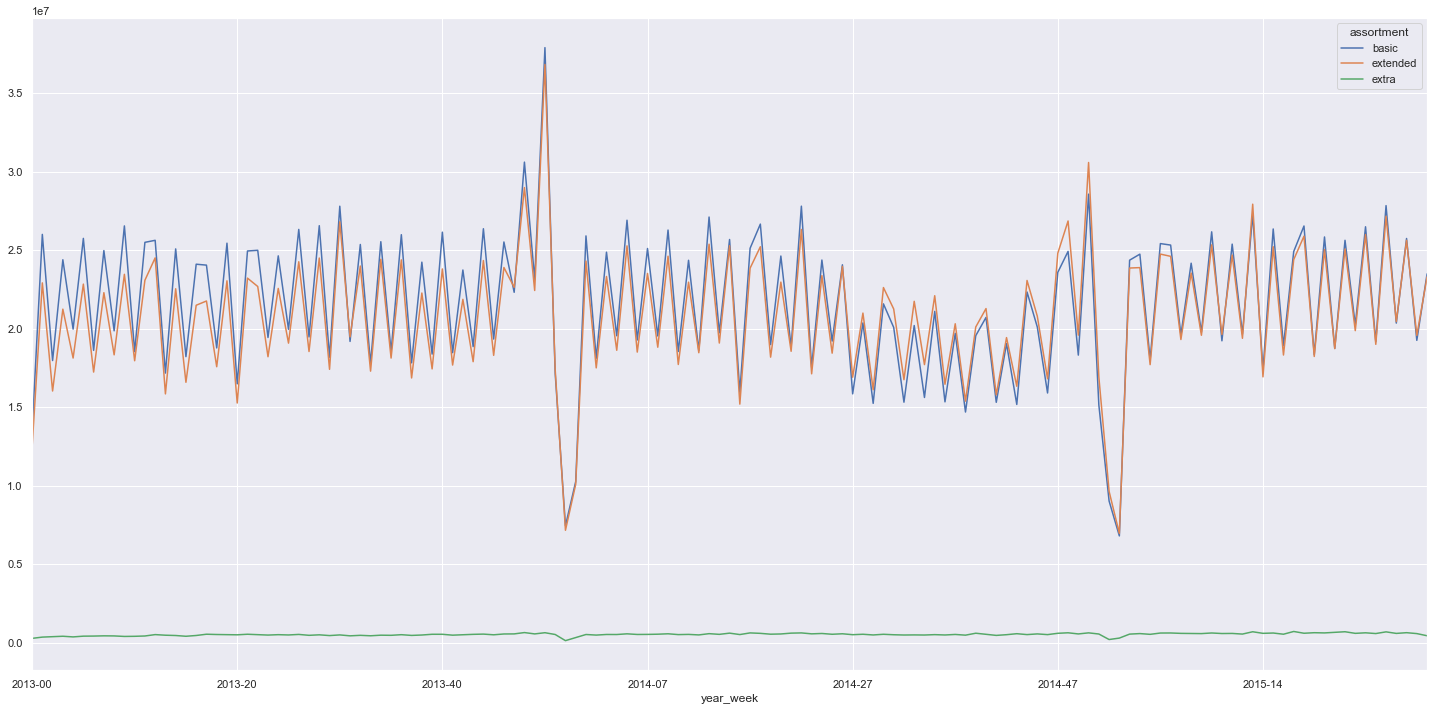

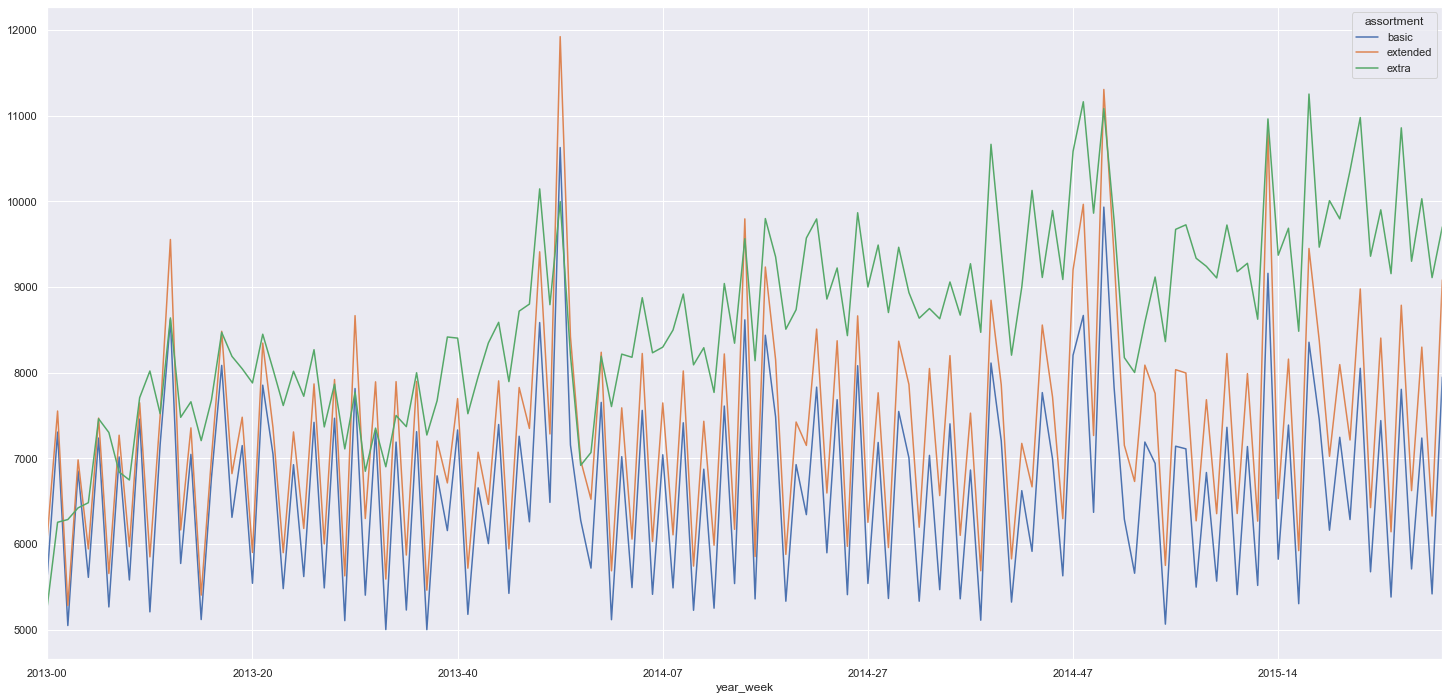

In [74]:
aux_sum.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()
aux_mean.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.

Pelos gráficos podemos notar que não há correlação entre distância dos competidores e vendas

In [75]:
aux1 = len(df4.store.unique())
aux2 = len(df4.loc[df4.competition_distance<20000,'store'].unique())
aux3 = len(df4.loc[df4.competition_distance<2000,'store'].unique())
aux4 = len(df4.loc[df4.competition_distance<200,'store'].unique())
aux5 = len(df4.competition_distance.unique())
print(f'O número de lojas no dataframe é {aux1}')
print(f'{aux2} lojas tem um competidor com menos de 20000 metros de distância')
print(f'{aux3} lojas tem um competidor com menos de 2000 metros de distância')
print(f'{aux4} lojas tem um competidor com menos de 200 metros de distância')
print(f'O número de diferentes "competition_distance" no dataframe é {aux5}')                   

O número de lojas no dataframe é 1115
1055 lojas tem um competidor com menos de 20000 metros de distância
501 lojas tem um competidor com menos de 2000 metros de distância
89 lojas tem um competidor com menos de 200 metros de distância
O número de diferentes "competition_distance" no dataframe é 655


Excluí entrada que está a 200000 metros de distância para melhorar o gráfico

Pelo gráfico das médias de venda para cada distância é possível notar que não há uma relação tão clara entre distância do competidor e quantidade de vendas

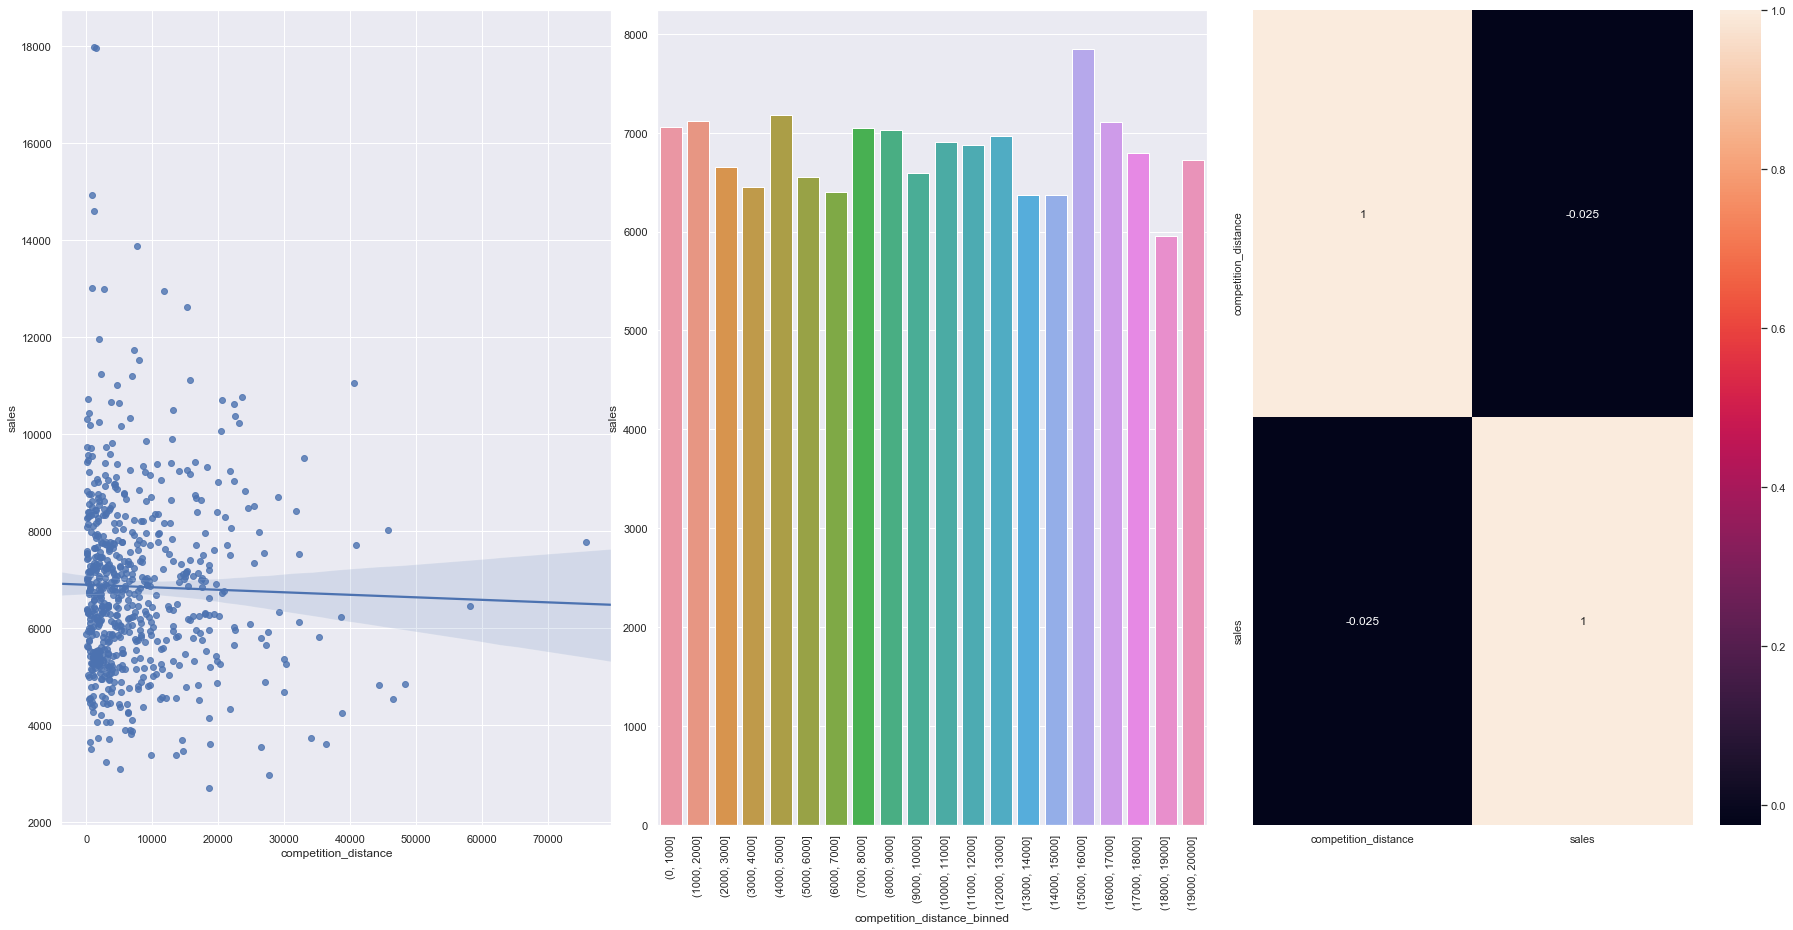

In [76]:
#define subplots
fig, ax = plt.subplots(1, 3)
fig.tight_layout()

aux_mean = df4.loc[df4.competition_distance<100000,['competition_distance','sales']].groupby('competition_distance').mean().reset_index()
sns.regplot(x='competition_distance',y='sales',data=aux_mean,ax=ax[0])

# Separando as distâncias em grupos de 1000 até 20000 metros
bins = np.arange(0,20001,1000)
aux_mean['competition_distance_binned'] = pd.cut(aux_mean.competition_distance,bins)
aux_mean2 = aux_mean[['competition_distance_binned','sales']].groupby('competition_distance_binned').mean().reset_index()
#plt.xticks(rotation=90)
ax[1].tick_params('x',labelrotation=90)
sns.barplot(x='competition_distance_binned',y='sales',data=aux_mean2,ax=ax[1])


sns.heatmap(aux_mean.corr(), annot=True, ax=ax[2])

Agora vou fazer os mesmos gráficos para distâncias até 20000 metros

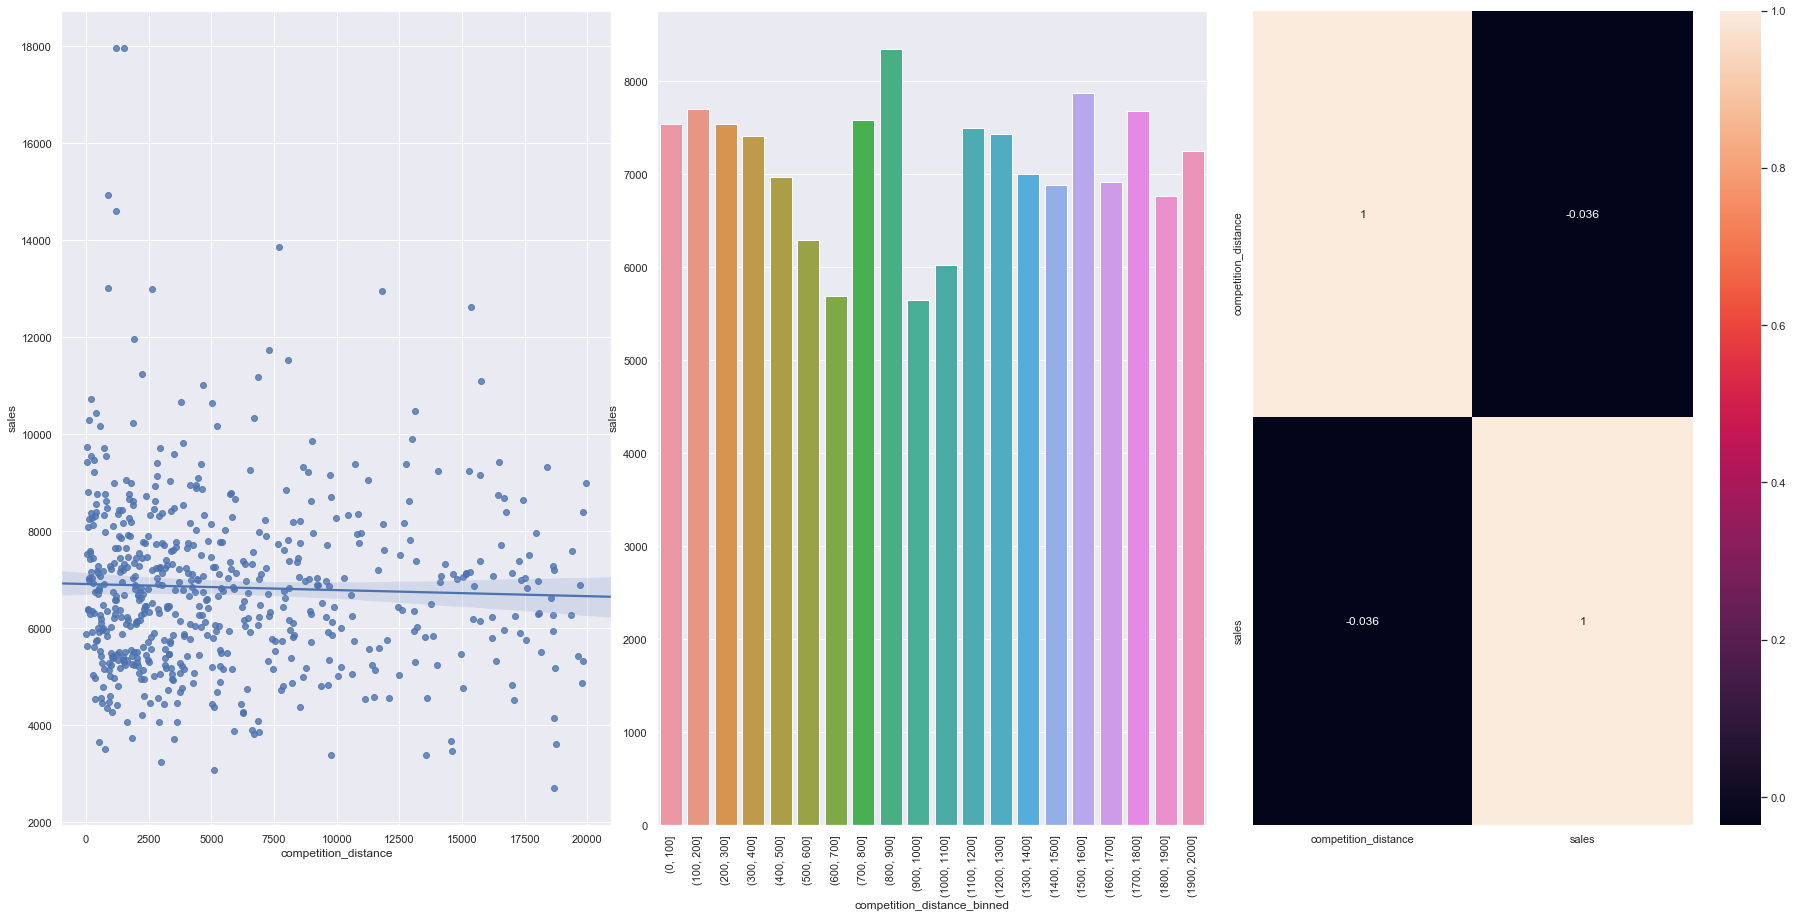

In [77]:
#define subplots
fig, ax = plt.subplots(1, 3)
fig.tight_layout()

aux_mean = df4.loc[df4.competition_distance<20001,['competition_distance','sales']].groupby('competition_distance').mean().reset_index()
sns.regplot(x='competition_distance',y='sales',data=aux_mean,ax=ax[0])

# Separando as distâncias em grupos de 1000 até 2000 metros
bins = np.arange(0,2001,100)
aux_mean['competition_distance_binned'] = pd.cut(aux_mean.competition_distance,bins)
aux_mean2 = aux_mean[['competition_distance_binned','sales']].groupby('competition_distance_binned').mean().reset_index()
#plt.xticks(rotation=90)
ax[1].tick_params('x',labelrotation=90)
sns.barplot(x='competition_distance_binned',y='sales',data=aux_mean2,ax=ax[1])


sns.heatmap(aux_mean.corr(), annot=True, ax=ax[2])

### H3. Lojas com competidores há mais tempo deveriam vender mais.
Pelos gráficos podemos notar que não há correlação entre tempo de competição e vendas

In [78]:
df4.competition_time_month.describe()

count    844338.000000
mean         41.679672
std          66.814412
min         -32.000000
25%           0.000000
50%          16.000000
75%          74.000000
max        1407.000000
Name: competition_time_month, dtype: float64

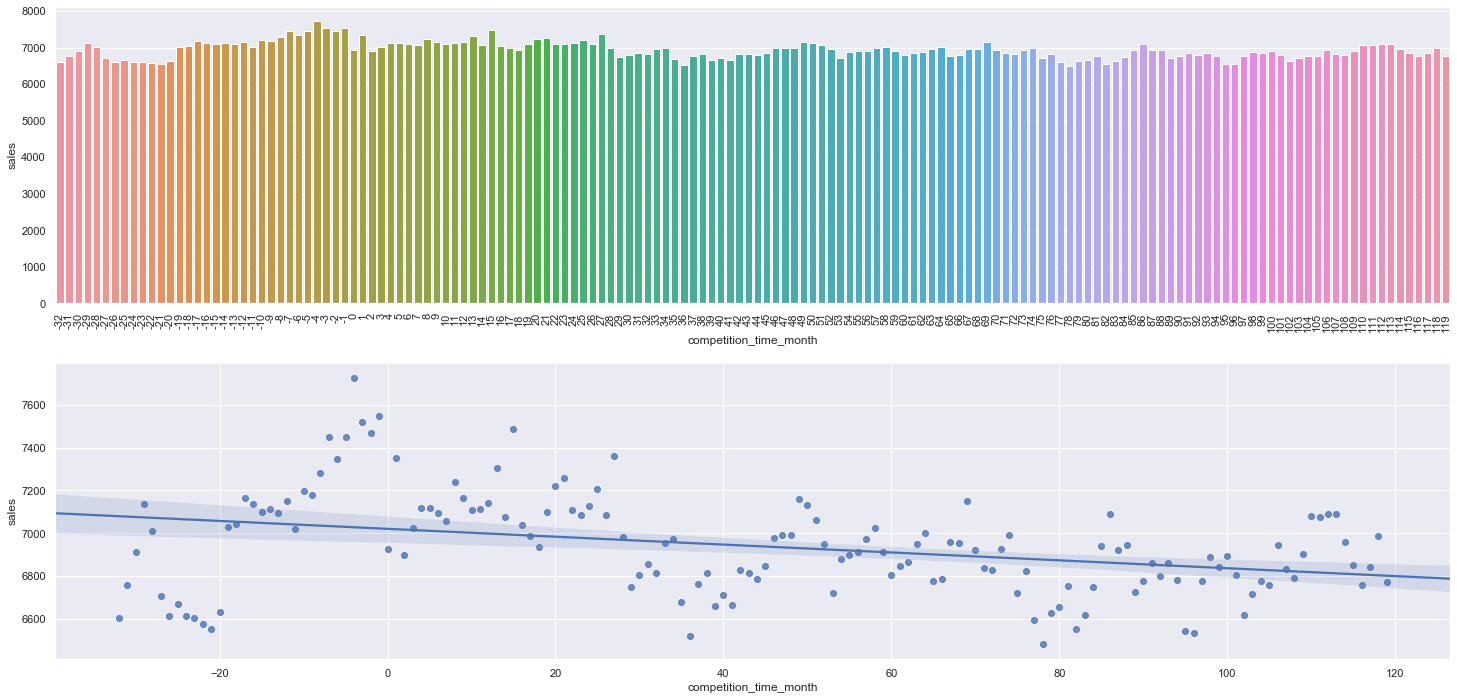

In [79]:
fig, ax = plt.subplots(2,1)

aux1 = df4.loc[df4.competition_time_month<120 ,['competition_time_month','sales']].groupby('competition_time_month').mean().reset_index()

sns.barplot(x='competition_time_month', y='sales', data=aux1, ax=ax[0])
#plt.xticks(rotation=90);
ax[0].tick_params('x', rotation=90)

sns.regplot(x='competition_time_month', y='sales', data=aux1, ax=ax[1])


In [80]:
df4[['competition_time_month','sales']].corr()

,competition_time_month,sales
competition_time_month,1.000000,-0.003571
sales,-0.003571,1.000000


### H4. Lojas com promoções ativas por mais tempo deveriam vender mais
Pelos gráficos e pela correlação de 0.46 a partir da semana que a promoção extendida se inicia, a afirmação é verdadeira.

O valor 0 é o que mais aparece nessa feature

In [81]:
df4.promo_time_week.describe()

count    844338.000000
mean         54.400699
std          85.457559
min        -126.000000
25%           0.000000
50%           0.000000
75%         109.000000
max         313.000000
Name: promo_time_week, dtype: float64

In [82]:
df4.promo_time_week.value_counts()

 0      421646
 52       3910
 98       1872
 102      1847
 97       1830
         ...  
-122        18
-123        18
-124        18
-125        18
-126        12
Name: promo_time_week, Length: 440, dtype: int64

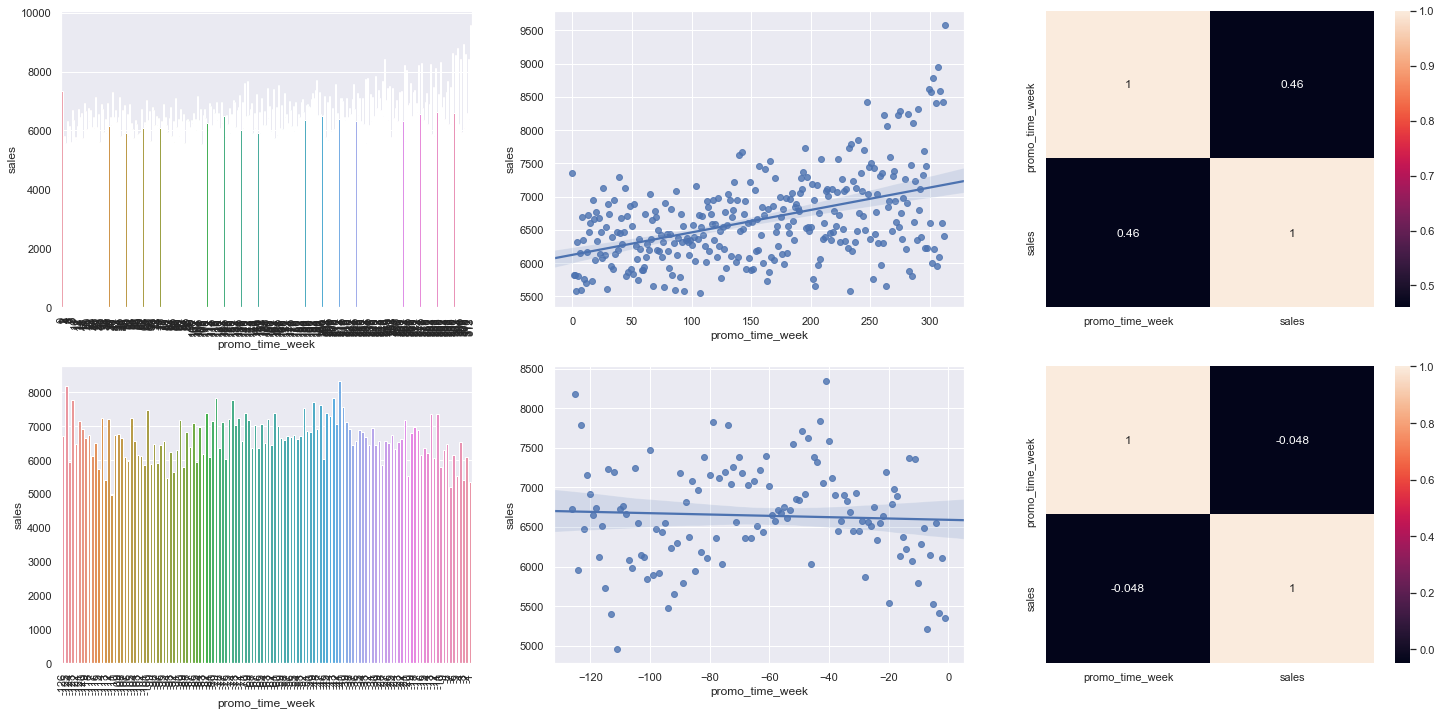

In [83]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').mean().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1.loc[aux1.promo_time_week>=0] #promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(grid[1,0])
aux3 = aux1.loc[aux1.promo_time_week<0] #promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[0,2])
sns.heatmap(aux2.corr(),annot=True)

plt.subplot(grid[1,2])
sns.heatmap(aux3.corr(),annot=True)



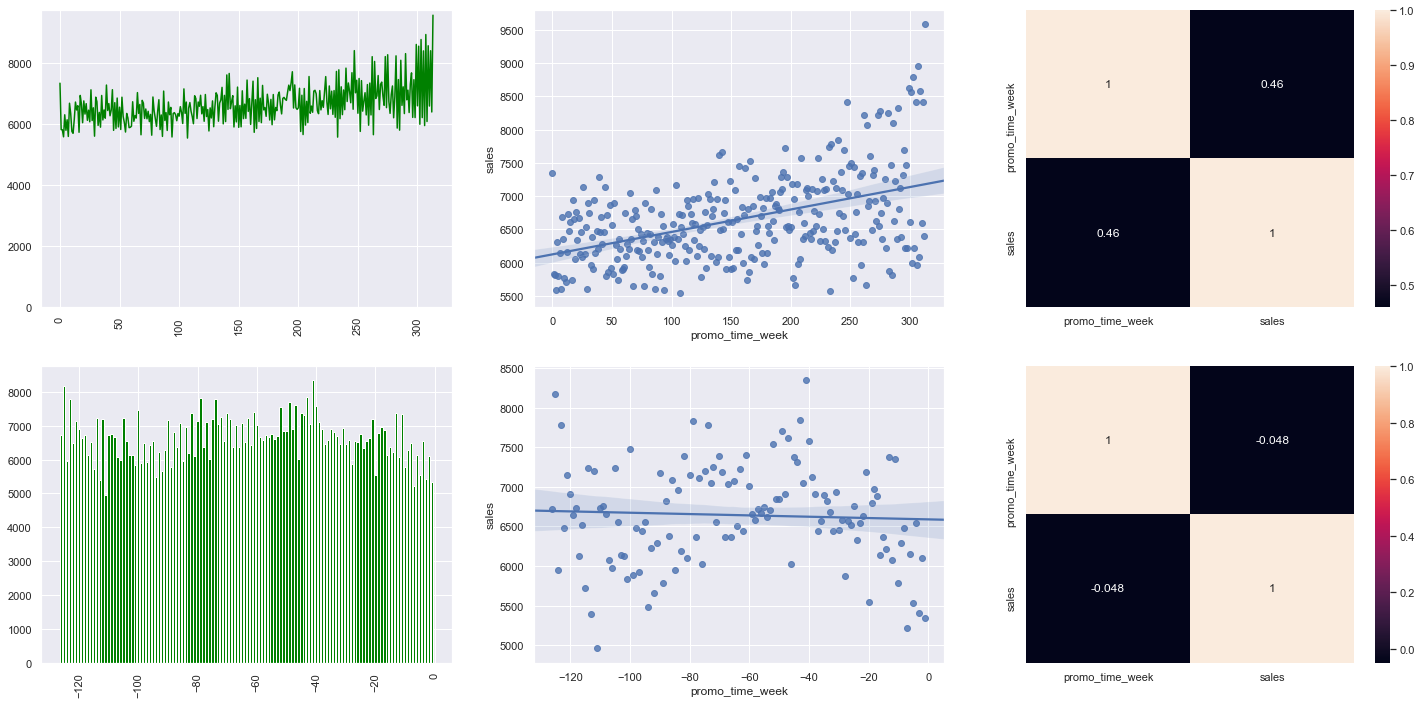

In [84]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').mean().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1.loc[aux1.promo_time_week>=0] #promo extendido
#sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.plot(aux2.promo_time_week, aux2.sales, color ='green')#, width = 0.0001)
plt.xticks(rotation=90);
plt.ylim(0,9750)

plt.subplot(grid[1,0])
aux3 = aux1.loc[aux1.promo_time_week<0] #promo regular
#sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.bar(aux3.promo_time_week, aux3.sales, color ='green')
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[0,2])
sns.heatmap(aux2.corr(),annot=True)

plt.subplot(grid[1,2])
sns.heatmap(aux3.corr(),annot=True)



In [85]:
display(aux1[['promo_time_week','sales']].corr())
display(aux2[['promo_time_week','sales']].corr())
display(aux3[['promo_time_week','sales']].corr())

,promo_time_week,sales
promo_time_week,1.000000,0.239049
sales,0.239049,1.000000


,promo_time_week,sales
promo_time_week,1.000000,0.460497
sales,0.460497,1.000000


,promo_time_week,sales
promo_time_week,1.000000,-0.048384
sales,-0.048384,1.000000


### <s>H5. Lojas com mais dias de promoção deveriam vender mais </s>
Essa hipótese será analisada no próximo ciclo



### H6. Lojas com mais promoções consecutivas deveriam vender mais
Lojas com promoções consecutivas venderam menos em média que as lojas só com promoção tradicional

In [86]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index().sort_values('sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


In [87]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).mean().reset_index().sort_values('sales')

,promo,promo2,sales
1,0,1,5529.566684
0,0,0,6328.187633
3,1,1,7836.672987
2,1,0,8618.452062


In [88]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).count()

sales
promo promo2        
0     0       234287
      1       233176
1     0       189005
      1       187870

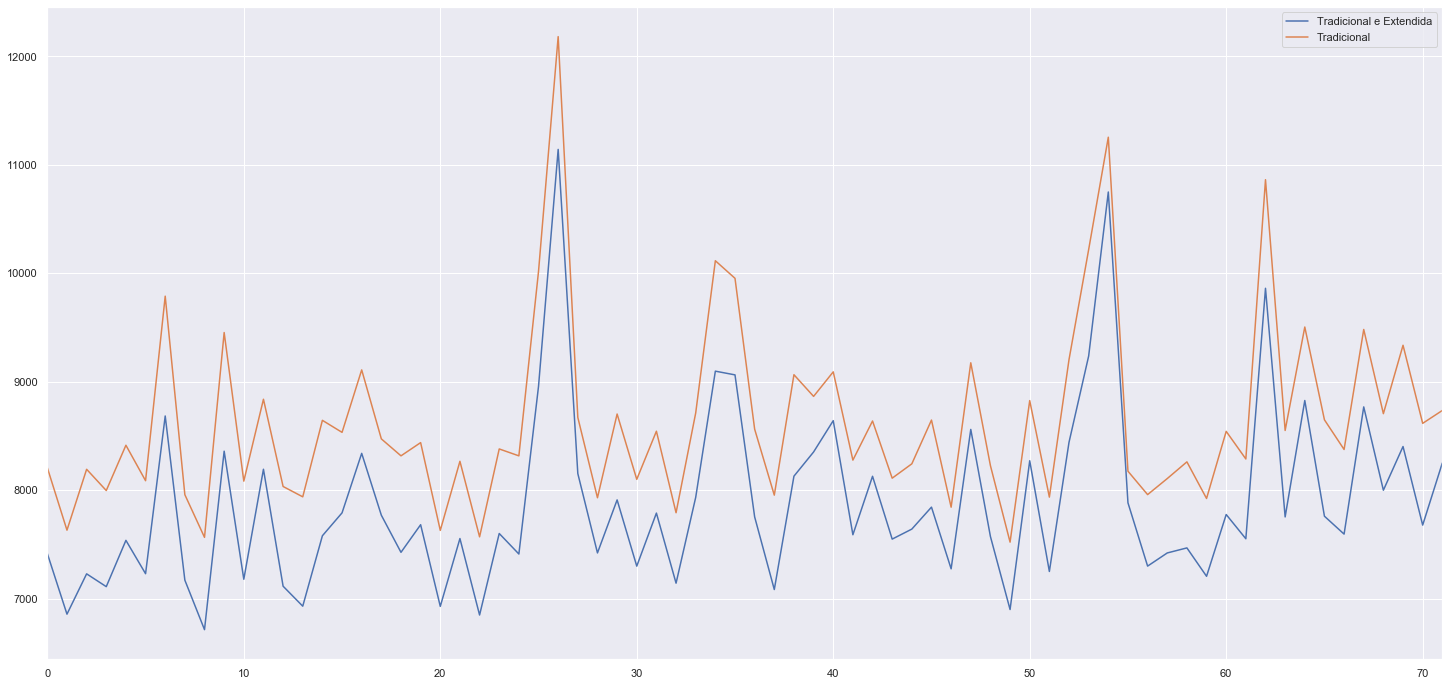

In [89]:
aux1 = df4.loc[(df4.promo==1) & (df4.promo2==1), ['year_week','sales']].groupby('year_week').mean().reset_index()
ax = aux1.plot()

aux2 = df4.loc[(df4.promo==1) & (df4.promo2==0), ['year_week','sales']].groupby('year_week').mean().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Extendida','Tradicional'])


### H7. Lojas abertas durante o feriado de Natal deveriam vender mais
Em média, vendem mais que em public holiday e regular day, e praticamente igual a easter holiday.

In [90]:
df4.state_holiday.value_counts()

regular_day       843428
public_holiday       694
easter_holiday       145
christmas             71
Name: state_holiday, dtype: int64

In [91]:
df4[['state_holiday','sales']].groupby('state_holiday').mean()

,sales
state_holiday,
christmas,9743.746479
easter_holiday,9887.889655
public_holiday,8487.471182
regular_day,6953.960229


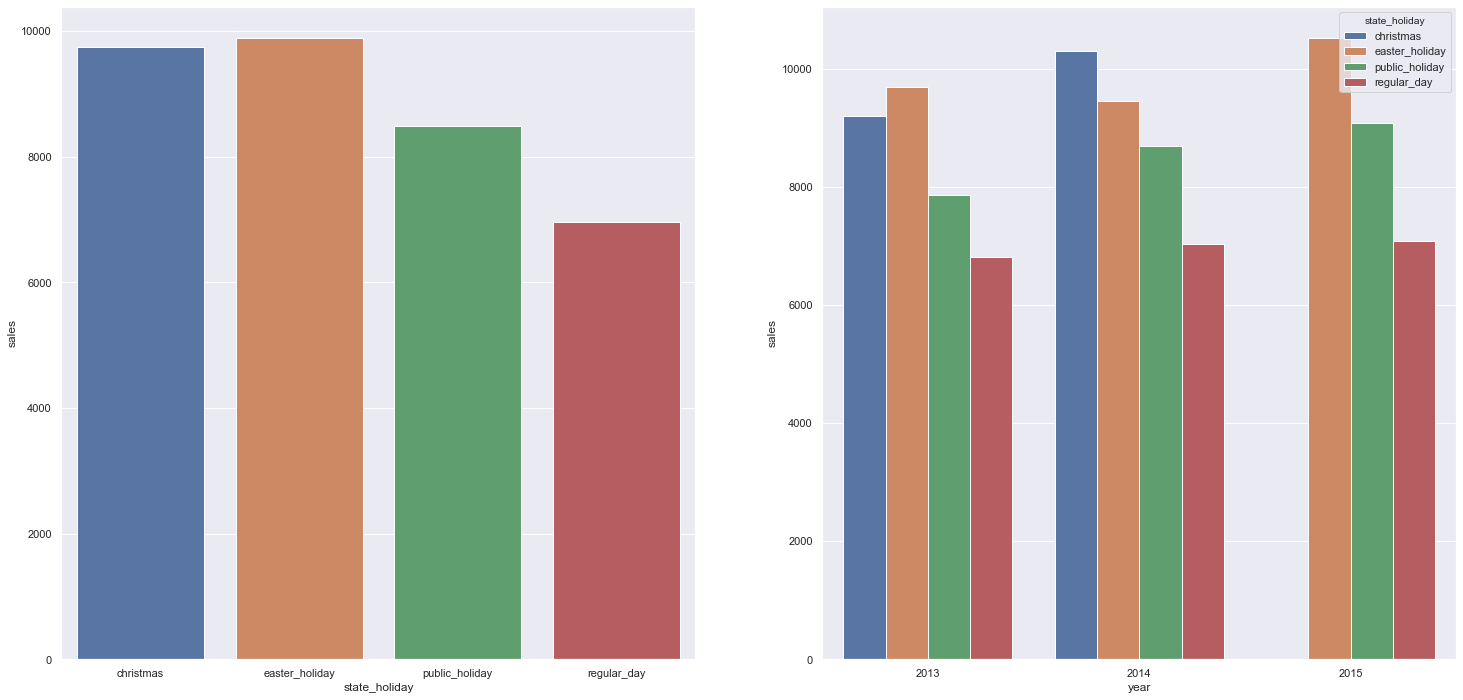

In [92]:
subplot(1,2,1)
sns.barplot(x = 'state_holiday', y = 'sales', data = df4[['state_holiday','sales']].groupby('state_holiday').mean().reset_index())

subplot(1,2,2)
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = df4[['year','state_holiday','sales']].groupby(['year','state_holiday']).mean().reset_index())



### H8. Lojas deveriam vender mais ao longo dos anos
Aqui acontece algo interessante: a média de faturamento/dia cresce a cada ano (lembrar que o ano 2015 não está finalizado), porém a soma do faturamento de 2013 para 2014 diminui 5.3%. Ao longo dos anos o número de lojas se mantém em 1115. O que aconteceu é que em julho de 2014 aproximadamente 200 lojas fecharam, ou nao registraram vendas. Talvez seja um erro nos dados. Isso fez com que a soma de vendas caísse de 2013 para 2014. Porém a média de vendas é maior, como esperado.

**Uma hipótese a ser verificada: a média de vendas no domingo é muito boa, porém poucas lojas são abertas. Vale a pena abrir mais lojas no domingo?**

In [93]:
df4[['year','sales']].groupby('year').mean()

,sales
year,
2013,6814.775168
2014,7026.128505
2015,7088.235123


In [94]:
df4[['year','sales']].groupby('year').sum()

,sales
year,
2013,2302876084
2014,2180804896
2015,1389499643


In [95]:
df4[['year','sales']].groupby('year').count()

,sales
year,
2013,337924
2014,310385
2015,196029


In [96]:
df4.sales.describe()

count    844338.000000
mean       6955.959134
std        3103.815515
min          46.000000
25%        4859.000000
50%        6369.000000
75%        8360.000000
max       41551.000000
Name: sales, dtype: float64

In [97]:
df2.sales.describe()

count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: sales, dtype: float64

Método para agrupar pela data. Função pd.Grouper

In [98]:
aux_date=df4[['date','store']].groupby(pd.Grouper(key='date', axis=0, 
                      freq='1D', sort=True)).count().reset_index()
aux_date

# outra forma
# df4[['date','store']].groupby([df4['date'].dt.date]).count()

,date,store
0,2013-01-01,17
1,2013-01-02,1111
2,2013-01-03,1109
3,2013-01-04,1108
4,2013-01-05,1107
...,...,...
937,2015-07-27,1113
938,2015-07-28,1113
939,2015-07-29,1113
940,2015-07-30,1113


Foi nesse gráfico que percebi algo estranho no ano de 2014. Há menos entradas por dia.

<BarContainer object of 212 artists>

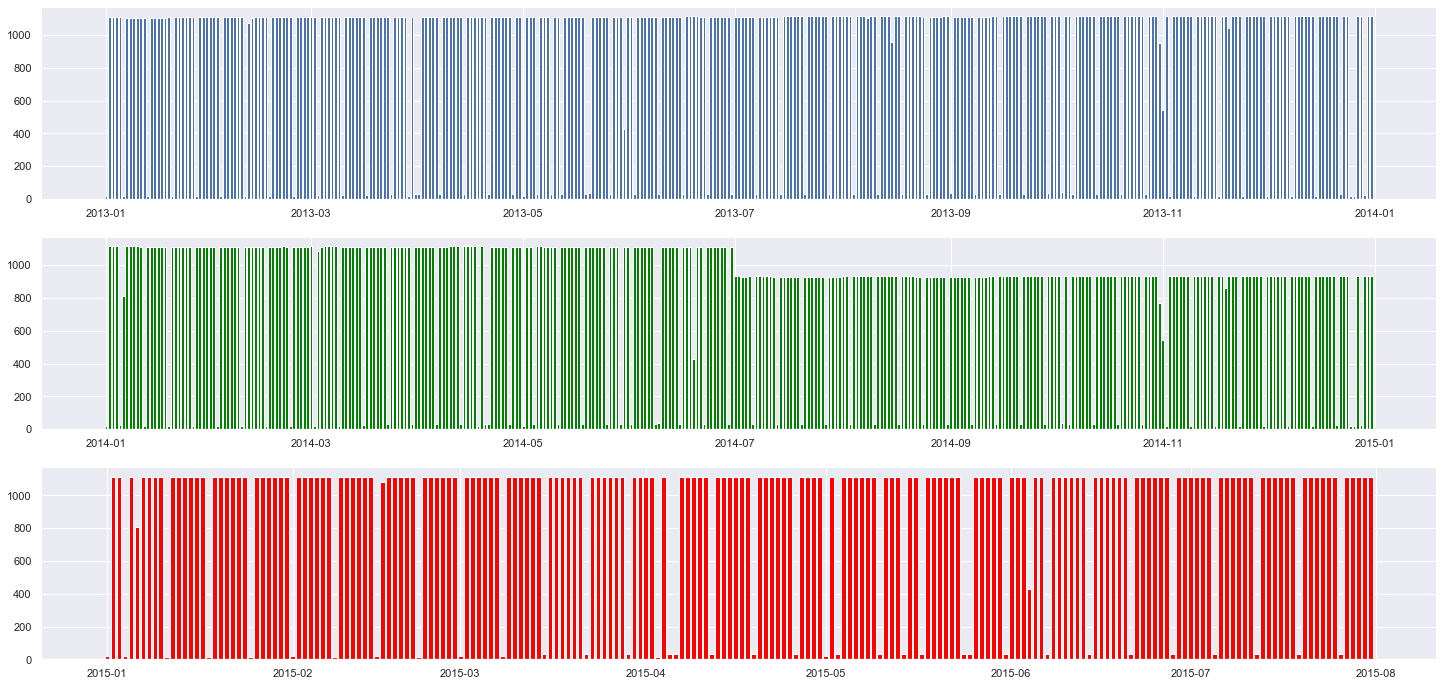

In [99]:
subplot(3,1,1)
# sns.barplot(x='date',y='store',data=aux_date.loc[aux_date.date.dt.year == 2013])
plt.bar(aux_date.loc[aux_date.date.dt.year == 2013,'date'], aux_date.loc[aux_date.date.dt.year == 2013,'store'])

subplot(3,1,2)
# sns.barplot(x='date',y='store',data=aux_date.loc[aux_date.date.dt.year == 2014])
plt.bar(aux_date.loc[aux_date.date.dt.year == 2014,'date'], aux_date.loc[aux_date.date.dt.year == 2014,'store'], color= 'green')

subplot(3,1,3)
# sns.barplot(x='date',y='store',data=aux_date.loc[aux_date.date.dt.year == 2015]'
plt.bar(aux_date.loc[aux_date.date.dt.year == 2015,'date'], aux_date.loc[aux_date.date.dt.year == 2015,'store'], color = 'red')



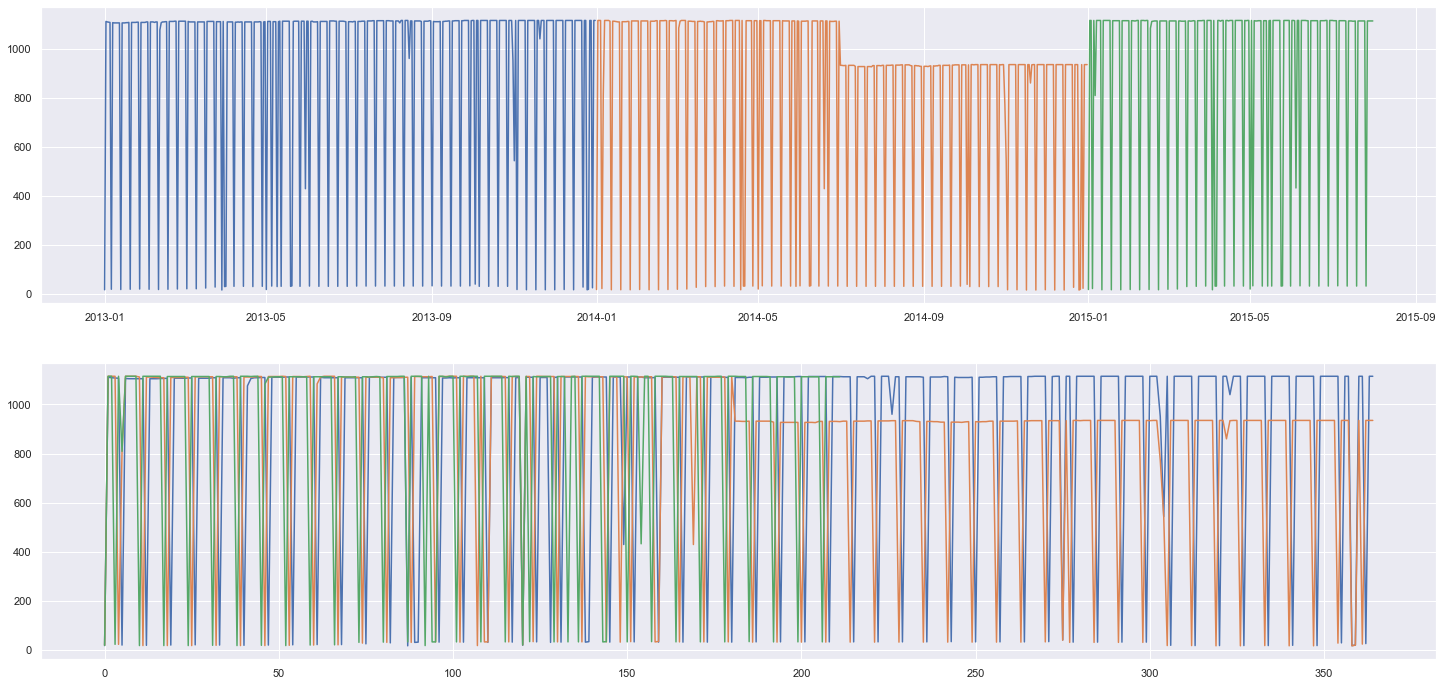

In [100]:
subplot(2,1,1)
plot(aux_date.loc[aux_date.date.dt.year == 2013,'date'], aux_date.loc[aux_date.date.dt.year == 2013,'store'])
plot(aux_date.loc[aux_date.date.dt.year == 2014,'date'], aux_date.loc[aux_date.date.dt.year == 2014,'store'])
plot(aux_date.loc[aux_date.date.dt.year == 2015,'date'], aux_date.loc[aux_date.date.dt.year == 2015,'store'])

subplot(2,1,2)
plot(aux_date.loc[aux_date.date.dt.year == 2013,'store'])
plot(aux_date.loc[aux_date.date.dt.year == 2014,'store'].reset_index(drop=True))
plot(aux_date.loc[aux_date.date.dt.year == 2015,'store'].reset_index(drop=True))

### H9. Lojas deveriam vender mais no segundo semestre
A média de vendas é praticamente igual ao longo do ano, com exceção do mês de Dezembro, onde há um aumento significativo

In [101]:
df4[['year','month','sales']].groupby(['year','month']).mean()

sales
year month             
2013 1      6240.506045
     2      6428.838730
     3      7213.092718
     4      6579.791664
     5      7077.028245
     6      6467.745839
     7      6923.613645
     8      6596.367019
     9      6363.615547
     10     6473.347016
     11     6904.509503
     12     8613.455299
2014 1      6540.313756
     2      6678.536710
     3      6654.709671
     4      7227.587658
     5      6948.119518
     6      7251.213362
     7      6893.938590
     8      6714.305191
     9      6758.808923
     10     6757.598370
     11     7539.603854
     12     8603.805210
2015 1      6913.177694
     2      6660.519241
     3      7071.483992
     4      7349.110170
     5      7308.779203
     6      7295.618795
     7      7033.344905

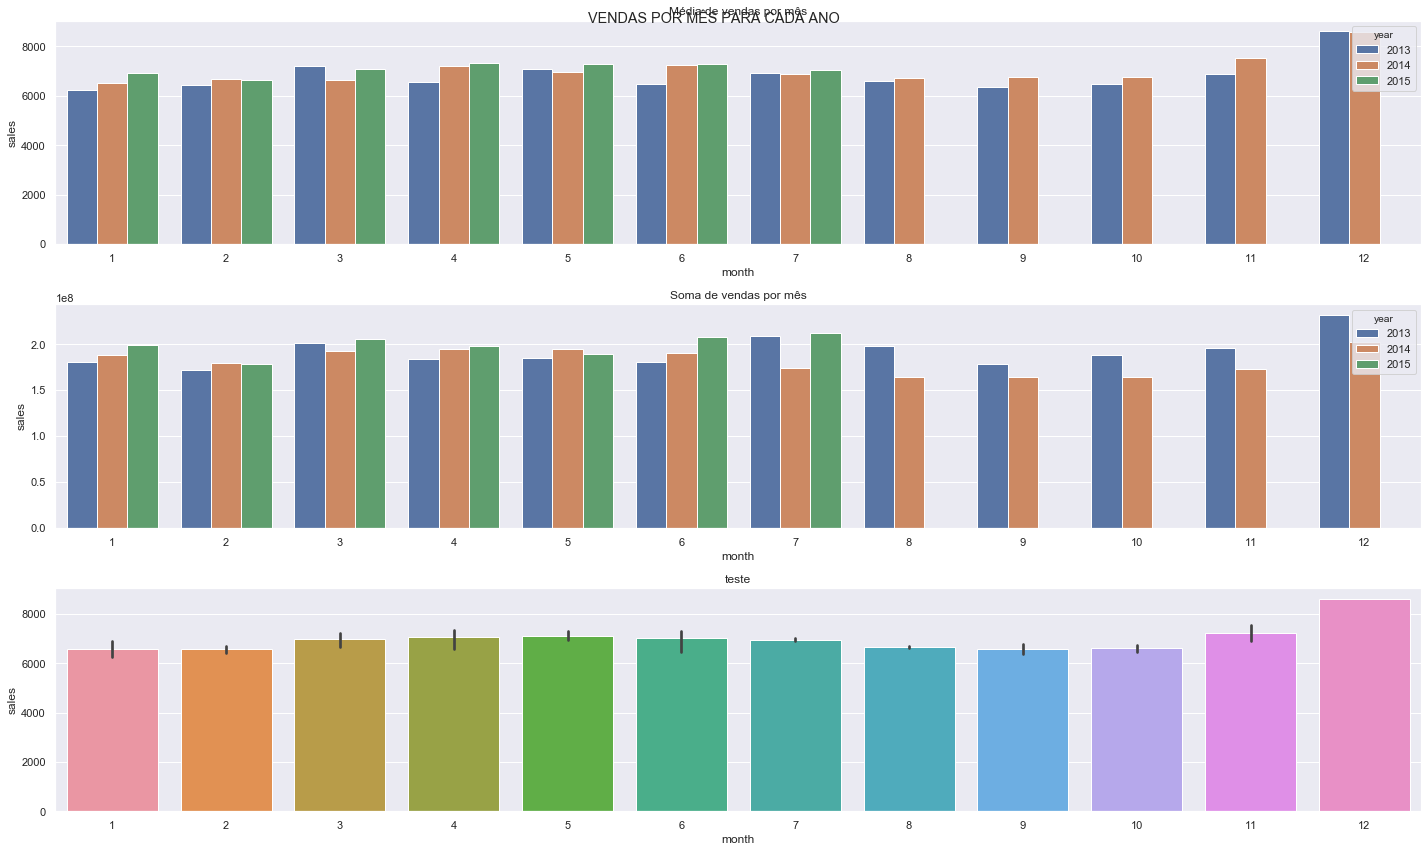

In [102]:
fig, [ax1, ax2, ax3] = plt.subplots(3,1,figsize=(20,12))

plt.suptitle('VENDAS POR MÊS PARA CADA ANO') # o título está por cima do subtítulo e nao sei corrigir
#subplot(3,1,1)
#plt.title('Média de vendas por mês')
ax1.set_title('Média de vendas por mês')
sns.barplot(x='month', y='sales', data=df4[['year','month','sales']].groupby(['year','month']).mean().reset_index(),hue='year',ax=ax1)


#subplot(3,1,2)
#plt.title('Soma de vendas por mês')
ax2.set_title('Soma de vendas por mês')
sns.barplot(x='month', y='sales', data=df4[['year','month','sales']].groupby(['year','month']).sum().reset_index(),hue='year',ax=ax2)


#subplot(3,1,3)
ax3.set_title('teste')
sns.barplot(x='month', y='sales', data=df4[['year','month','sales']].groupby(['year','month']).mean().reset_index(),ax=ax3)

fig.tight_layout()

### H10. Lojas deveriam vender mais depois do dia dez de cada mês
A média de vendas é um pouco maior antes do dia dez

In [103]:
# Criando coluna categórica para dias antes e depois do dia 10
df4['before_after'] = 1
df4.loc[df4.day<=10,['before_after']] = 0
print(f'Número de observações para cada setor do mês:\n{(df4.before_after.value_counts())}')

#Criando variáveis auxiliares para médias e somas para dia e before_after
aux_mean=df4[['before_after','sales']].groupby('before_after').mean().reset_index()
aux_sum_day=df4[['day','sales']].groupby('day').sum().reset_index()
aux_mean_day=df4[['day','sales']].groupby('day').mean().reset_index()
display(aux_mean)

Número de observações para cada setor do mês:
1    573935
0    270403
Name: before_after, dtype: int64


,before_after,sales
0,0,7286.921051
1,1,6800.030160


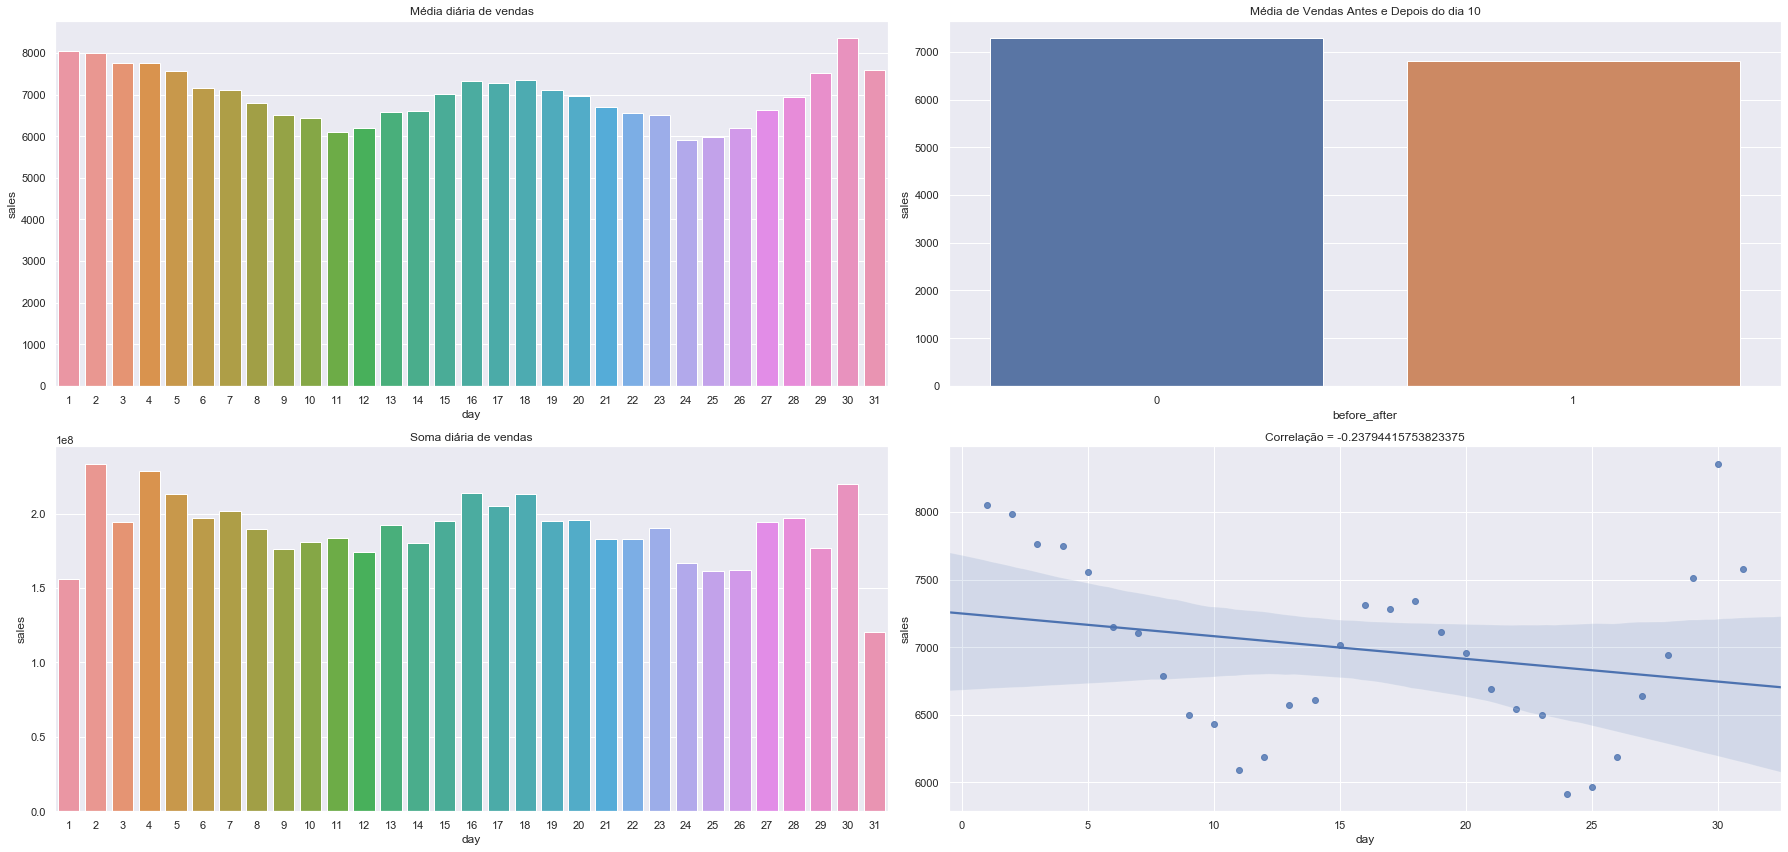

In [104]:
#define subplots
fig, ax = plt.subplots(2, 2)

sns.barplot(x='day',y='sales', data=aux_mean_day, ax=ax[0,0])
ax[0,0].set_title('Média diária de vendas')

#subplot(3,1,2)
#sns.barplot(x='before_after',y='sales',hue = 'day', data=df4)
sns.barplot(x='day',y='sales', data=aux_sum_day, ax=ax[1,0])
ax[1,0].set_title('Soma diária de vendas')

# Poderia usar o df4 no lugar do aux, porém fica mais lento
#subplot(3,1,3)
sns.barplot(x='before_after',y='sales',data=aux_mean, ax=ax[0,1])
#plt.title('Média de Vendas Antes e Depois do dia 10')
ax[0,1].set_title('Média de Vendas Antes e Depois do dia 10')

sns.regplot(x='day',y='sales',data=aux_mean_day,ax=ax[1,1])
ax[1,1].set_title('Correlação = {}'.format(aux_mean_day.corr().values[0][1]))


plt.tight_layout()

### H11. Lojas deveriam vender menos nos finais de semana 
O volume de vendas no Domingo é menor pois há menos lojas abertas. Porém, a média de vendas é a maior de todas.
O sábado tem uma média muito inferior mesmo com o mesmo número de lojas abertas que nos dias úteis. A média do fim de semana acaba se tornando menor (5932) que nos dias úteis (7173).

In [105]:
df4.day_of_week.value_counts()

6    144052
2    143955
3    141922
5    138633
1    137557
4    134626
7      3593
Name: day_of_week, dtype: int64

In [106]:
aux_mean = df4.groupby('day_of_week').sales.mean().reset_index()
aux_sum = df4.groupby('day_of_week').sales.sum().reset_index()
display(aux_mean)
display(aux_sum)

,day_of_week,sales
0,1,8216.252259
1,2,7088.409086
2,3,6728.786679
3,4,6768.214973
4,5,7073.034133
5,6,5875.084935
6,7,8224.723908


,day_of_week,sales
0,1,1130203012
1,2,1020411930
2,3,954962863
3,4,911177709
4,5,980555941
5,6,846317735
6,7,29551433


O volume de vendas no Domingo é menor pois há menos lojas abertas. Porém, a média de vendas é a maior de todas.

[Text(0.5, 1.0, 'Soma de Vendas por dia da semana')]

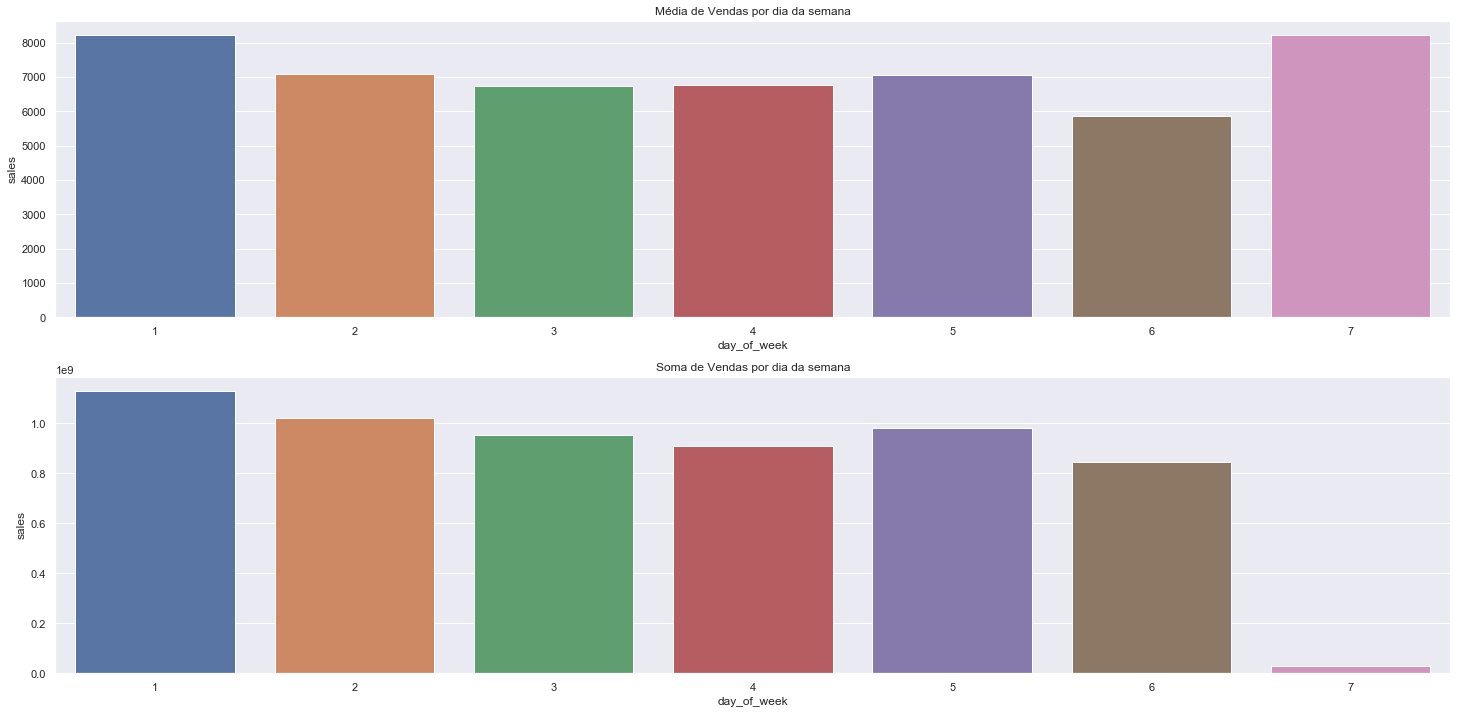

In [107]:
fig, [ax1, ax2] = plt.subplots(2,1)
sns.barplot(x='day_of_week',y='sales',data=aux_mean,ax=ax1)
sns.barplot(x='day_of_week',y='sales',data=aux_sum,ax=ax2)

ax1.set(title = 'Média de Vendas por dia da semana')
ax2.set(title = 'Soma de Vendas por dia da semana')

In [108]:
mean_weekend = df4.loc[(df4.day_of_week == 6) | (df4.day_of_week == 7), ['sales'] ].mean()
mean_workday = df4.loc[(df4.day_of_week != 6) & (df4.day_of_week != 7), ['sales'] ].mean()

print(mean_weekend)
print(mean_workday)

sales    5932.264337
dtype: float64
sales    7172.903208
dtype: float64


### H12. Lojas deveriam vender  menos durante feriados escolares
As lojas que abrem nos feriados, vendem mais na média.

In [109]:
mean_school = df4[['sales','school_holiday']].groupby('school_holiday').mean().reset_index()
sum_school = df4[['sales','school_holiday']].groupby('school_holiday').sum().reset_index()
mean_month_school = df4[['month','sales','school_holiday']].groupby(['month','school_holiday']).mean().reset_index()
sum_month_school = df4[['month','sales','school_holiday']].groupby(['month','school_holiday']).sum().reset_index()

display(mean_school)
display(sum_school)
display(df4.school_holiday.value_counts())
display(mean_month_school)
display(sum_month_school)


,school_holiday,sales
0,0,6897.207830
1,1,7200.710282


,school_holiday,sales
0,0,4696260531
1,1,1176920092


0    680893
1    163445
Name: school_holiday, dtype: int64

,month,school_holiday,sales
0,1,0,6491.437432
1,1,1,7077.306231
2,2,0,6535.954457
3,2,1,7117.668788
4,3,0,6783.626268
5,3,1,8889.577533
6,4,0,6985.868198
7,4,1,7235.930139
8,5,0,7097.032454
9,5,1,7220.653300


,month,school_holiday,sales
0,1,0,490739687
1,1,1,75989037
2,2,0,476170426
3,2,1,52563984
4,3,0,529719808
5,3,1,70112098
6,4,0,432131835
7,4,1,143763460
8,5,0,523512599
9,5,1,45735618


[Text(0.5, 1.0, 'Soma de vendas por mês')]

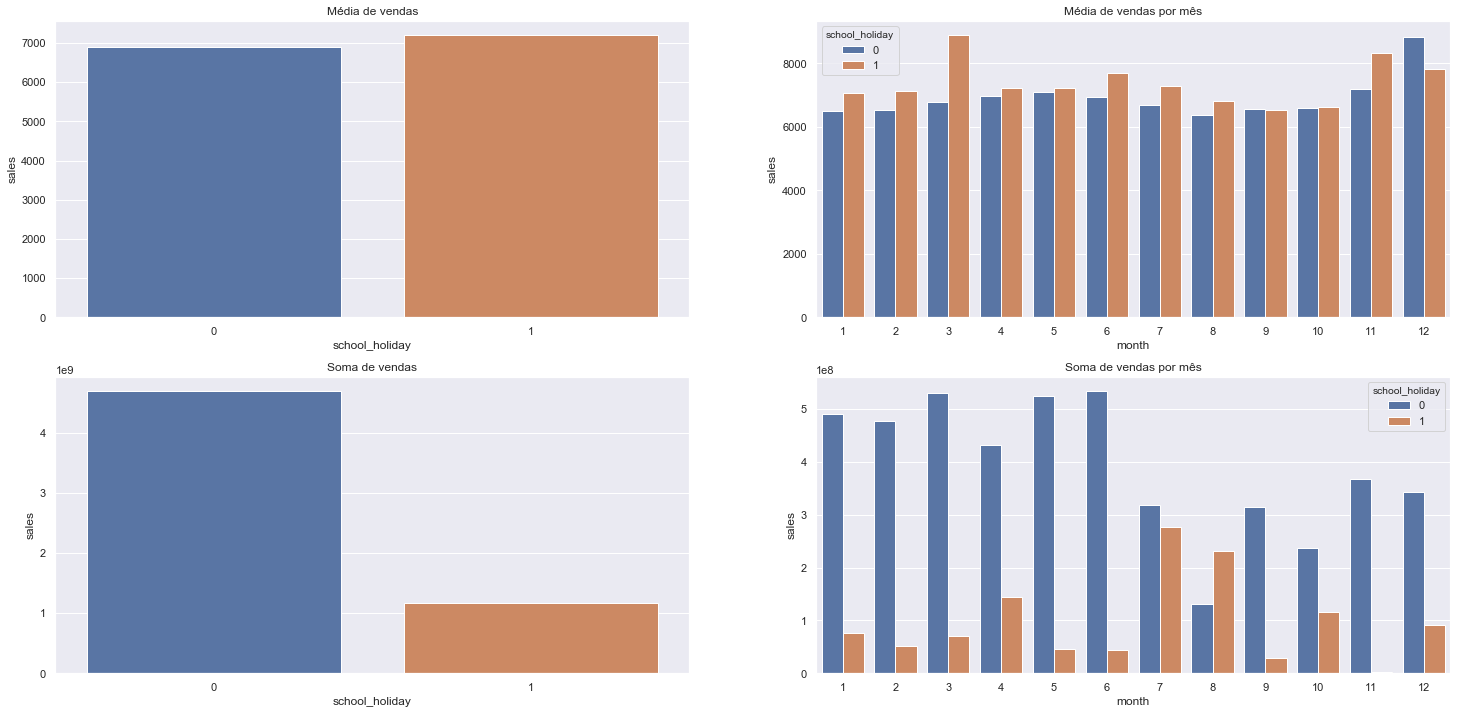

In [110]:
fig, ax = plt.subplots(2,2)

sns.barplot(x='school_holiday',y='sales',data=mean_school,ax=ax[0,0])
sns.barplot(x='school_holiday',y='sales',data=sum_school,ax=ax[1,0])
sns.barplot(x='month',y='sales',hue='school_holiday',data=mean_month_school,ax=ax[0,1])
sns.barplot(x='month',y='sales',hue='school_holiday',data=sum_month_school,ax=ax[1,1])

ax[0,0].set(title='Média de vendas')
ax[1,0].set(title='Soma de vendas')
ax[0,1].set(title='Média de vendas por mês')
ax[1,1].set(title='Soma de vendas por mês')

### 4.2.1 Resumo das Hipóteses
Não editei. Versão do Meigarom.

In [111]:
from tabulate import tabulate

In [112]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes 

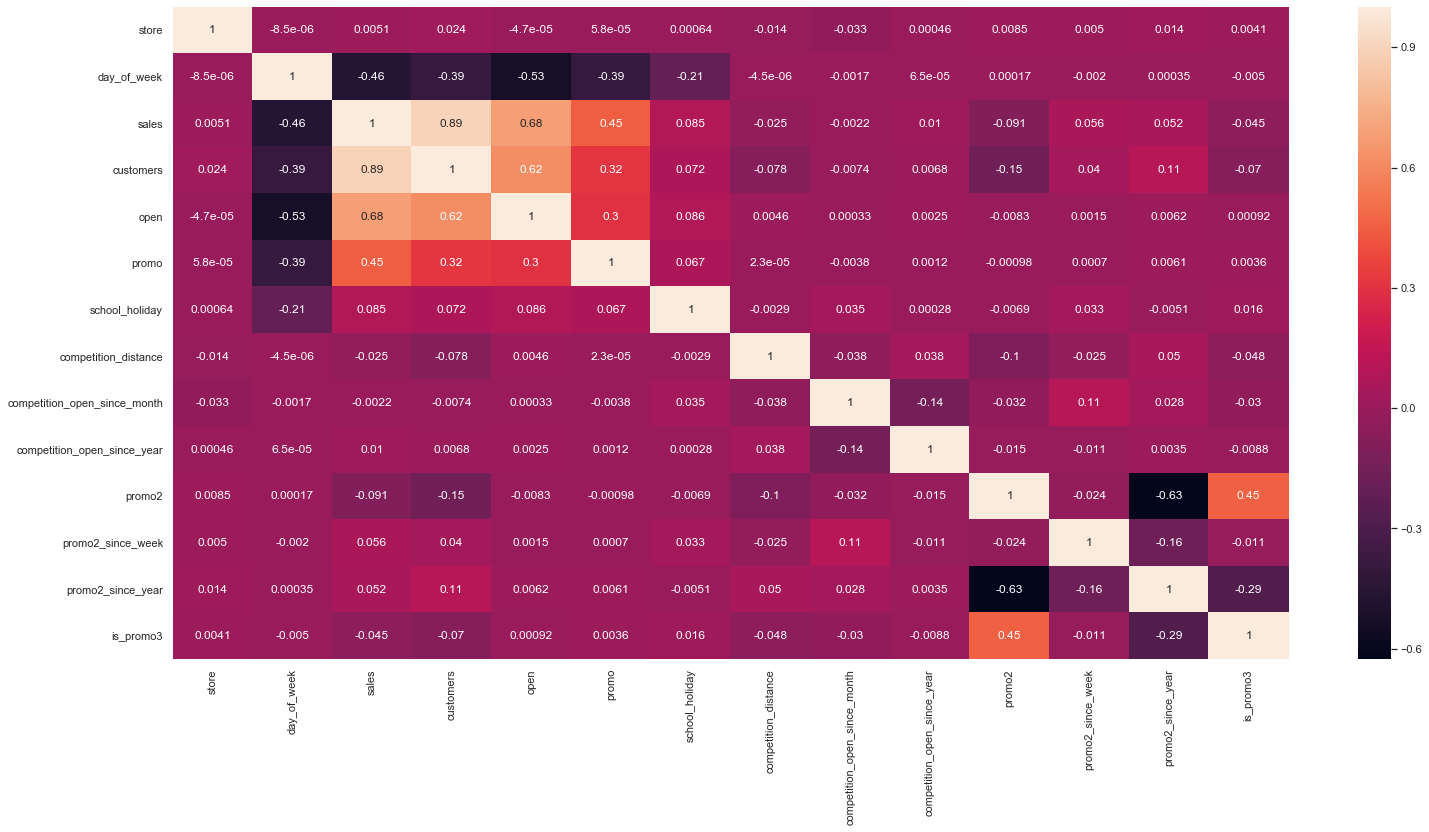

In [113]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation,annot=True)

### 4.3.2 Categorical Attributes

In [114]:
# only categorical data

a = df4.select_dtypes(include='object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


Cálculo do Cramér's V

In [115]:
cm = pd.crosstab(a.state_holiday,a.store_type).values
cm

array([[     4,     66,      0,      1],
       [    36,    100,      0,      9],
       [   236,    285,     65,    108],
       [456766,  15109, 112903, 258650]])

In [116]:
cramer_v(a.state_holiday,a.store_type)

0.071039693758565

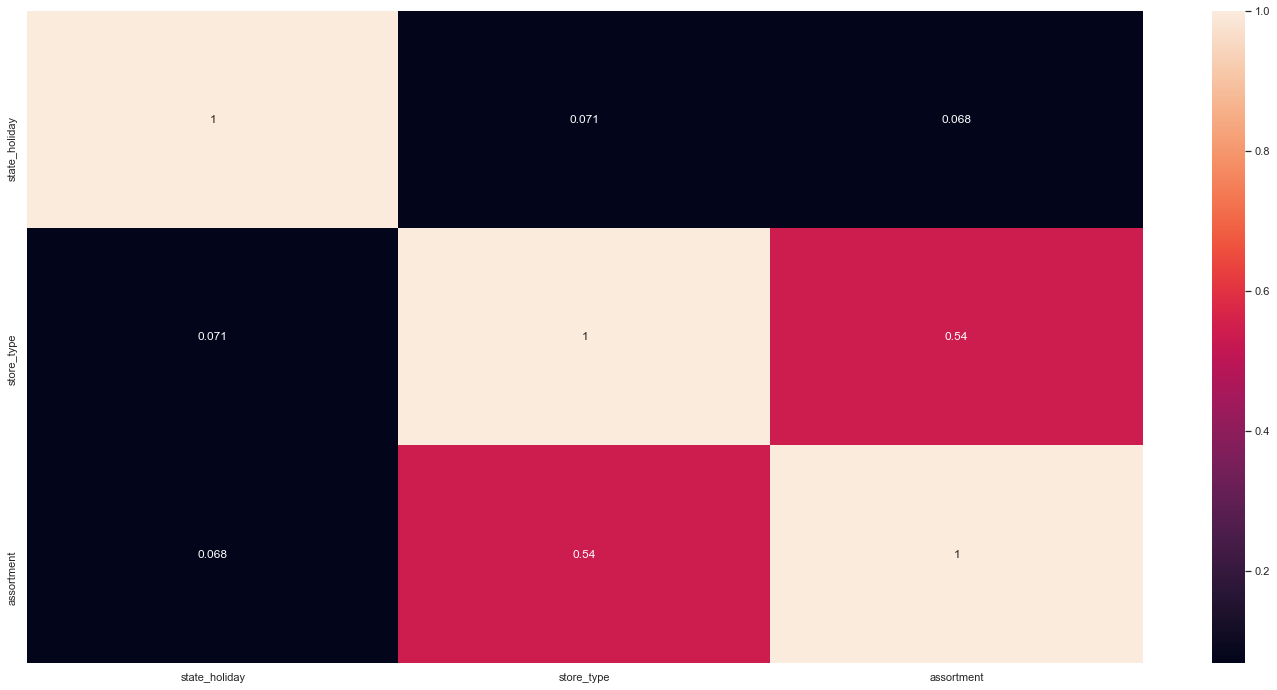

In [117]:
# Calculating cramer V
a1 = cramer_v(a.state_holiday,a.state_holiday)
a2 = cramer_v(a.state_holiday,a.store_type)
a3 = cramer_v(a.state_holiday,a.assortment)

a4 = cramer_v(a.store_type,a.state_holiday)
a5 = cramer_v(a.store_type,a.store_type)
a6 = cramer_v(a.store_type,a.assortment)

a7 = cramer_v(a.assortment,a.state_holiday)
a8 = cramer_v(a.assortment,a.store_type)
a9 = cramer_v(a.assortment,a.assortment)

# Final dataframe
d = pd.DataFrame({'state_holiday':[a1,a2,a3],
              'store_type':[a4,a5,a6],
              'assortment':[a7,a8,a9]})

d = d.set_index(d.columns)

sns.heatmap(d,annot=True)

Outra forma de fazer usando a biblioteca PyCorr

In [118]:
from pycorrcat.pycorrcat import plot_corr, corr_matrix

In [119]:
a.columns

Index(['state_holiday', 'store_type', 'assortment', 'year_week'], dtype='object')

In [120]:
correlation_matrix = corr_matrix(a, ['state_holiday', 'store_type', 'assortment'])
correlation_matrix

,state_holiday,store_type,assortment
state_holiday,1.000000,0.071040,0.067519
store_type,0.071040,1.000000,0.538454
assortment,0.067519,0.538454,1.000000


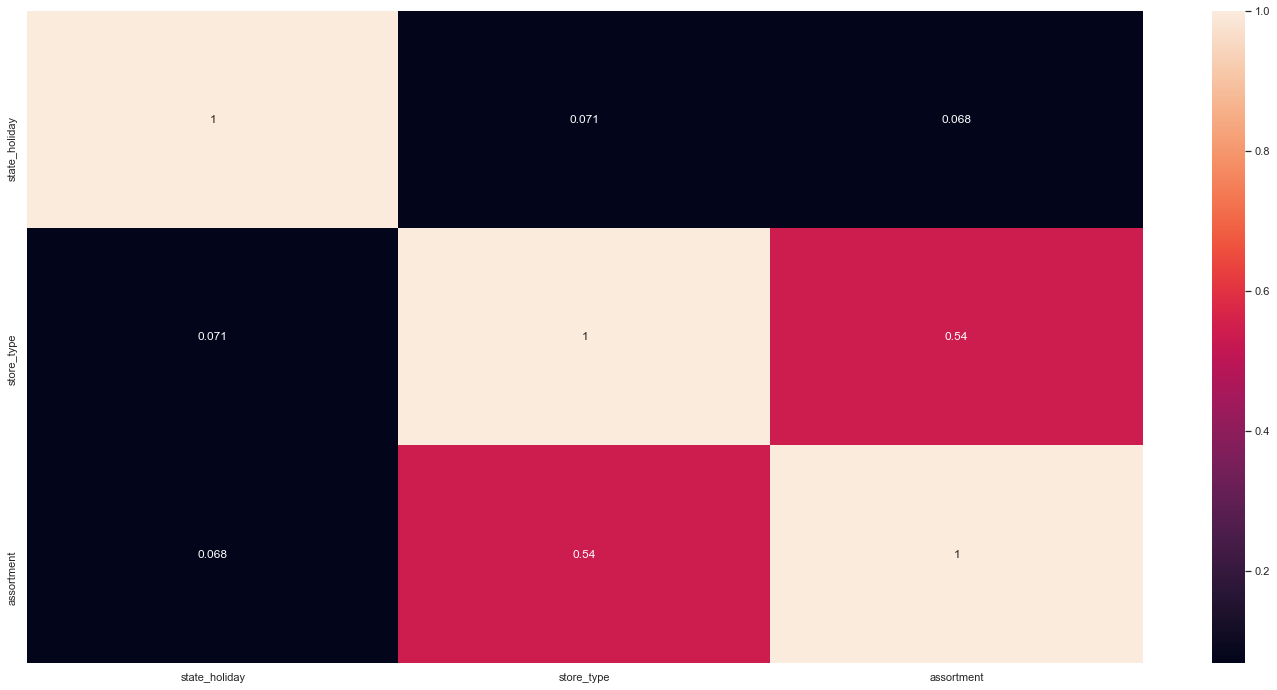

In [121]:
plot_corr(a, ['state_holiday', 'store_type', 'assortment'] )

# 5.0 Passo 05 - Data Preparation

In [122]:
df5 = df4.copy()

## 5.1 Normalização
Variáveis com distribuição normal

## 5.2 Rescaling

In [217]:
rs = RobustScaler() # quando tem muito outlier
mms = MinMaxScaler() # quando não tem muito outlier

# 'competition_distance'
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
# 'year'
df5['year'] = mms.fit_transform(df5[['year']].values)
# 'competition_time_month'
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
# 'promo_time_week'
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

## 5.3 Transformação

### 5.3.1 Encoding

In [163]:
df5.sample(5,random_state=42)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo3,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,before_after,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
50431,257,2,2015-06-16,5934,1,0,0,1,-0.308065,12,2012,0,25,2015,0,1.0,6,16,25,2015-24,2012-12-01,0.189189,2015-06-15,0.287016,1,0,0,0,1
679368,4,3,2013-10-30,7800,0,0,2,3,-0.275806,9,2009,0,44,2013,0,0.0,10,30,44,2013-43,2009-09-01,0.459459,2013-10-28,0.287016,1,0,0,0,1
289237,593,3,2014-11-05,9111,1,0,0,3,4.956452,3,2010,0,45,2014,0,0.5,11,5,45,2014-44,2010-03-01,0.554054,2014-11-03,0.287016,0,0,0,0,1
828685,1026,3,2013-06-19,7831,1,0,2,1,-0.303226,6,2011,1,48,2012,1,0.0,6,19,25,2013-24,2011-06-01,0.108108,2012-11-19,0.355353,1,0,0,0,1
478683,19,1,2014-04-28,10046,1,0,0,3,0.146774,4,2014,1,22,2011,0,0.5,4,28,18,2014-17,2014-04-01,-0.216216,2011-05-23,0.635535,1,0,0,0,1


In [156]:
# 'state_holiday' - One Hot Encoding
df5 = pd.get_dummies(df5,prefix=['state_holiday'],columns=['state_holiday'] )

# 'store_type' - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5.store_type)

# 'assortment' - Ordinal Encoding
assortment_dict = {'basic':1,'extra':2,'extended':3}
df5['assortment'] = df5.assortment.map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [168]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation
Transformação de natureza cíclica. Mudei algumas coisas feitas pelo Meigarom.
Xsin = sin(2pi*x/max(x))
Xcos = cos(2pi*x/max(x))

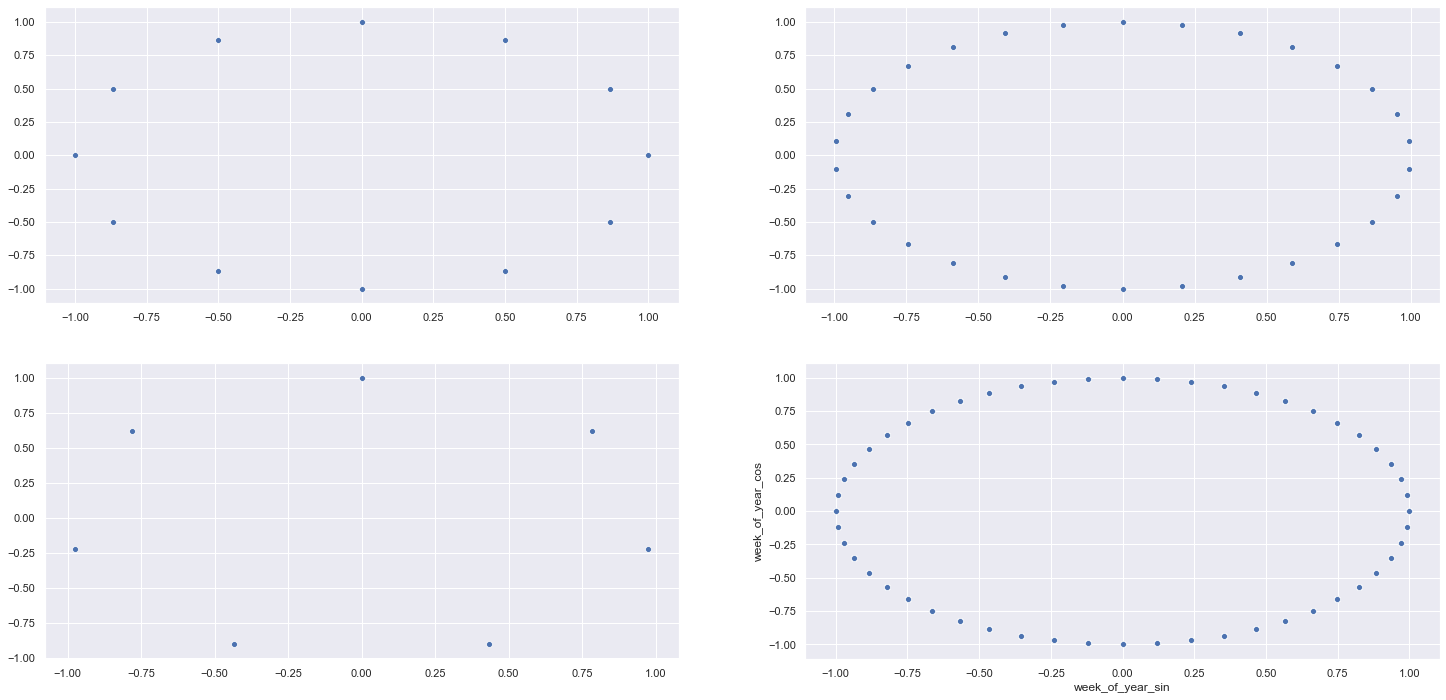

In [220]:
df5['month_sin'] = np.sin(df5.month*(2.*np.pi/12))
df5['month_cos'] = np.cos(df5.month*(2.*np.pi/12))

df5['day_of_week_sin'] = np.sin(df5.day_of_week*(2.*np.pi/7))
df5['day_of_week_cos'] = np.cos(df5.day_of_week*(2.*np.pi/7))

df5['day_sin'] = np.sin(df5.day*(2.*np.pi/30))
df5['day_cos'] = np.cos(df5.day*(2.*np.pi/30))

df5['week_of_year_sin'] = np.sin(df5.week_of_year*(2.*np.pi/52))
df5['week_of_year_cos'] = np.cos(df5.week_of_year*(2.*np.pi/52))

fig, ax = subplots(2,2)

sns.scatterplot(df5['month_sin'].unique(), df5['month_cos'].unique(),ax=ax[0][0])
sns.scatterplot(df5['day_sin'].unique(), df5['day_cos'].unique(),ax=ax[0][1])
sns.scatterplot(df5['day_of_week_sin'].unique(), df5['day_of_week_cos'].unique(),ax=ax[1][0])
sns.scatterplot(df5['week_of_year_sin'], df5['week_of_year_cos'],ax=ax[1][1]) # o numero de valores unicos estava diferente